In [1]:
import os
import sys
project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.insert(0, project_root)

import dill as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from itertools import combinations
from datasets import load_from_disk
from character.constants import DATA_PATH

/Users/student/Desktop/ai+design/character_elicitation/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tested_models = [
    "claude-haiku-4.5",
    "deepseek-v3.2",
    "gemini-3-flash-preview",
    "gpt-5.1",
    "grok-4.1-fast",
    "kimi-k2-thinking",
    "ministral-14b-2512",
    "qwen3-vl-235b-a22b-thinking",
    "trinity-mini",
    "gpt-4o",
    "deepseek-r1-0528"
]

display_names = {
    "claude-haiku-4.5": "Claude Haiku 4.5",
    "deepseek-v3.2": "DeepSeek V3.2",
    "gemini-3-flash-preview": "Gemini 3 Flash",
    "gpt-5.1": "GPT-5.1",
    "grok-4.1-fast": "Grok 4.1 Fast",
    "kimi-k2-thinking": "Kimi K2 Thinking",
    "ministral-14b-2512": "Ministral 14B",
    "qwen3-vl-235b-a22b-thinking": "Qwen3 VL 235B",
    "trinity-mini": "Trinity Mini",
    "gpt-4o": "GPT-4o",
    "deepseek-r1-0528": "Deepseek R1",
}

In [3]:
def calculate_elo_ratings(preferences, model_name, normalize=False):
    traits = set()
    for x, y, _ in preferences[model_name]:
        traits.add(x)
        traits.add(y)

    elo_ratings = {trait: 1000.0 for trait in traits}
    K = 32

    for trait1, trait2, winner in preferences[model_name]:
        r1 = elo_ratings[trait1]
        r2 = elo_ratings[trait2]
        e1 = 1 / (1 + 10**((r2 - r1) / 400))
        e2 = 1 / (1 + 10**((r1 - r2) / 400))
        
        if winner == trait1:
            elo_ratings[trait1] += K * (1 - e1)
            elo_ratings[trait2] += K * (0 - e2)
        elif winner == trait2:
            elo_ratings[trait1] += K * (0 - e1)
            elo_ratings[trait2] += K * (1 - e2)

    if normalize:
        min_rating = min(elo_ratings.values())
        max_rating = max(elo_ratings.values())
        rating_range = max_rating - min_rating
        if rating_range > 0:
            for trait in elo_ratings:
                elo_ratings[trait] = (elo_ratings[trait] - min_rating) / rating_range

    for k, v in elo_ratings.items():
        elo_ratings[k] = round(v, 2)
    return sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)

In [4]:
preferences_path = f"{DATA_PATH}/preferences"
files = [f for f in os.listdir(preferences_path) if f.endswith(".pkl")]
preferences = {}

for file in files:
    name = file.split(".pkl")[0]
    pkl_path = f"{preferences_path}/{file}"
    dataset_path = f"{preferences_path}/{name}"
    
    if not os.path.isdir(dataset_path):
        print(f"Skipping {name} (no dataset directory)")
        continue
    
    try:
        with open(pkl_path, "rb") as f:
            data = load_from_disk(dataset_path)
            winners = pickle.load(f)
            preferences[name] = [(t1, t2, winner) for t1, t2, winner in zip(data["trait_1"], data["trait_2"], winners) 
                                if winner and winner != "" and winner in [t1, t2]]
        print(f"Loaded {name}: {len(preferences[name])} comparisons")
    except Exception as e:
        print(f"Error loading {name}: {e}")

model_names = sorted(preferences.keys())
valid_models = [m for m in model_names if len(preferences[m]) > 5000]
print(f"\nLoaded {len(model_names)} models")
print(f"Valid models ({len(valid_models)} > 5000 comparisons): {valid_models}")

results = {}
for model in model_names:
    results[model] = calculate_elo_ratings(preferences, model, False)

Loaded ministral-14b-2512: 10006 comparisons
Loaded trinity-mini: 9925 comparisons
Loaded deepseek-v3.2: 10034 comparisons
Loaded gemini-3-flash-preview: 10216 comparisons
Loaded qwen3-vl-235b-a22b-thinking: 10182 comparisons
Loaded kimi-k2-thinking: 10019 comparisons
Loaded gpt-5.1: 10048 comparisons
Loaded claude-haiku-4.5: 10090 comparisons
Loaded grok-4.1-fast: 10084 comparisons

Loaded 9 models
Valid models (9 > 5000 comparisons): ['claude-haiku-4.5', 'deepseek-v3.2', 'gemini-3-flash-preview', 'gpt-5.1', 'grok-4.1-fast', 'kimi-k2-thinking', 'ministral-14b-2512', 'qwen3-vl-235b-a22b-thinking', 'trinity-mini']


In [24]:
trait_counts = {model: len(results[model]) for model in model_names}
for model, count in trait_counts.items():
    print(f"{model:40s}: {count} traits")

unique_counts = set(trait_counts.values())
if len(unique_counts) > 1:
    max_count = max(unique_counts)
    reference_model = [m for m, c in trait_counts.items() if c == max_count][0]
    reference_traits = {trait for trait, _ in results[reference_model]}
    
    print(f"\nMissing traits:")
    for model in model_names:
        model_traits = {trait for trait, _ in results[model]}
        missing = reference_traits - model_traits
        if missing:
            print(f"  {model}: {sorted(missing)}")

claude-haiku-4.5                        : 144 traits
deepseek-v3.2                           : 144 traits
gemini-3-flash-preview                  : 144 traits
gpt-5.1                                 : 144 traits
grok-4.1-fast                           : 144 traits
kimi-k2-thinking                        : 144 traits
ministral-14b-2512                      : 144 traits
qwen3-vl-235b-a22b-thinking             : 144 traits
trinity-mini                            : 144 traits


/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/3380001541.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, TIGHTPAD, 1])


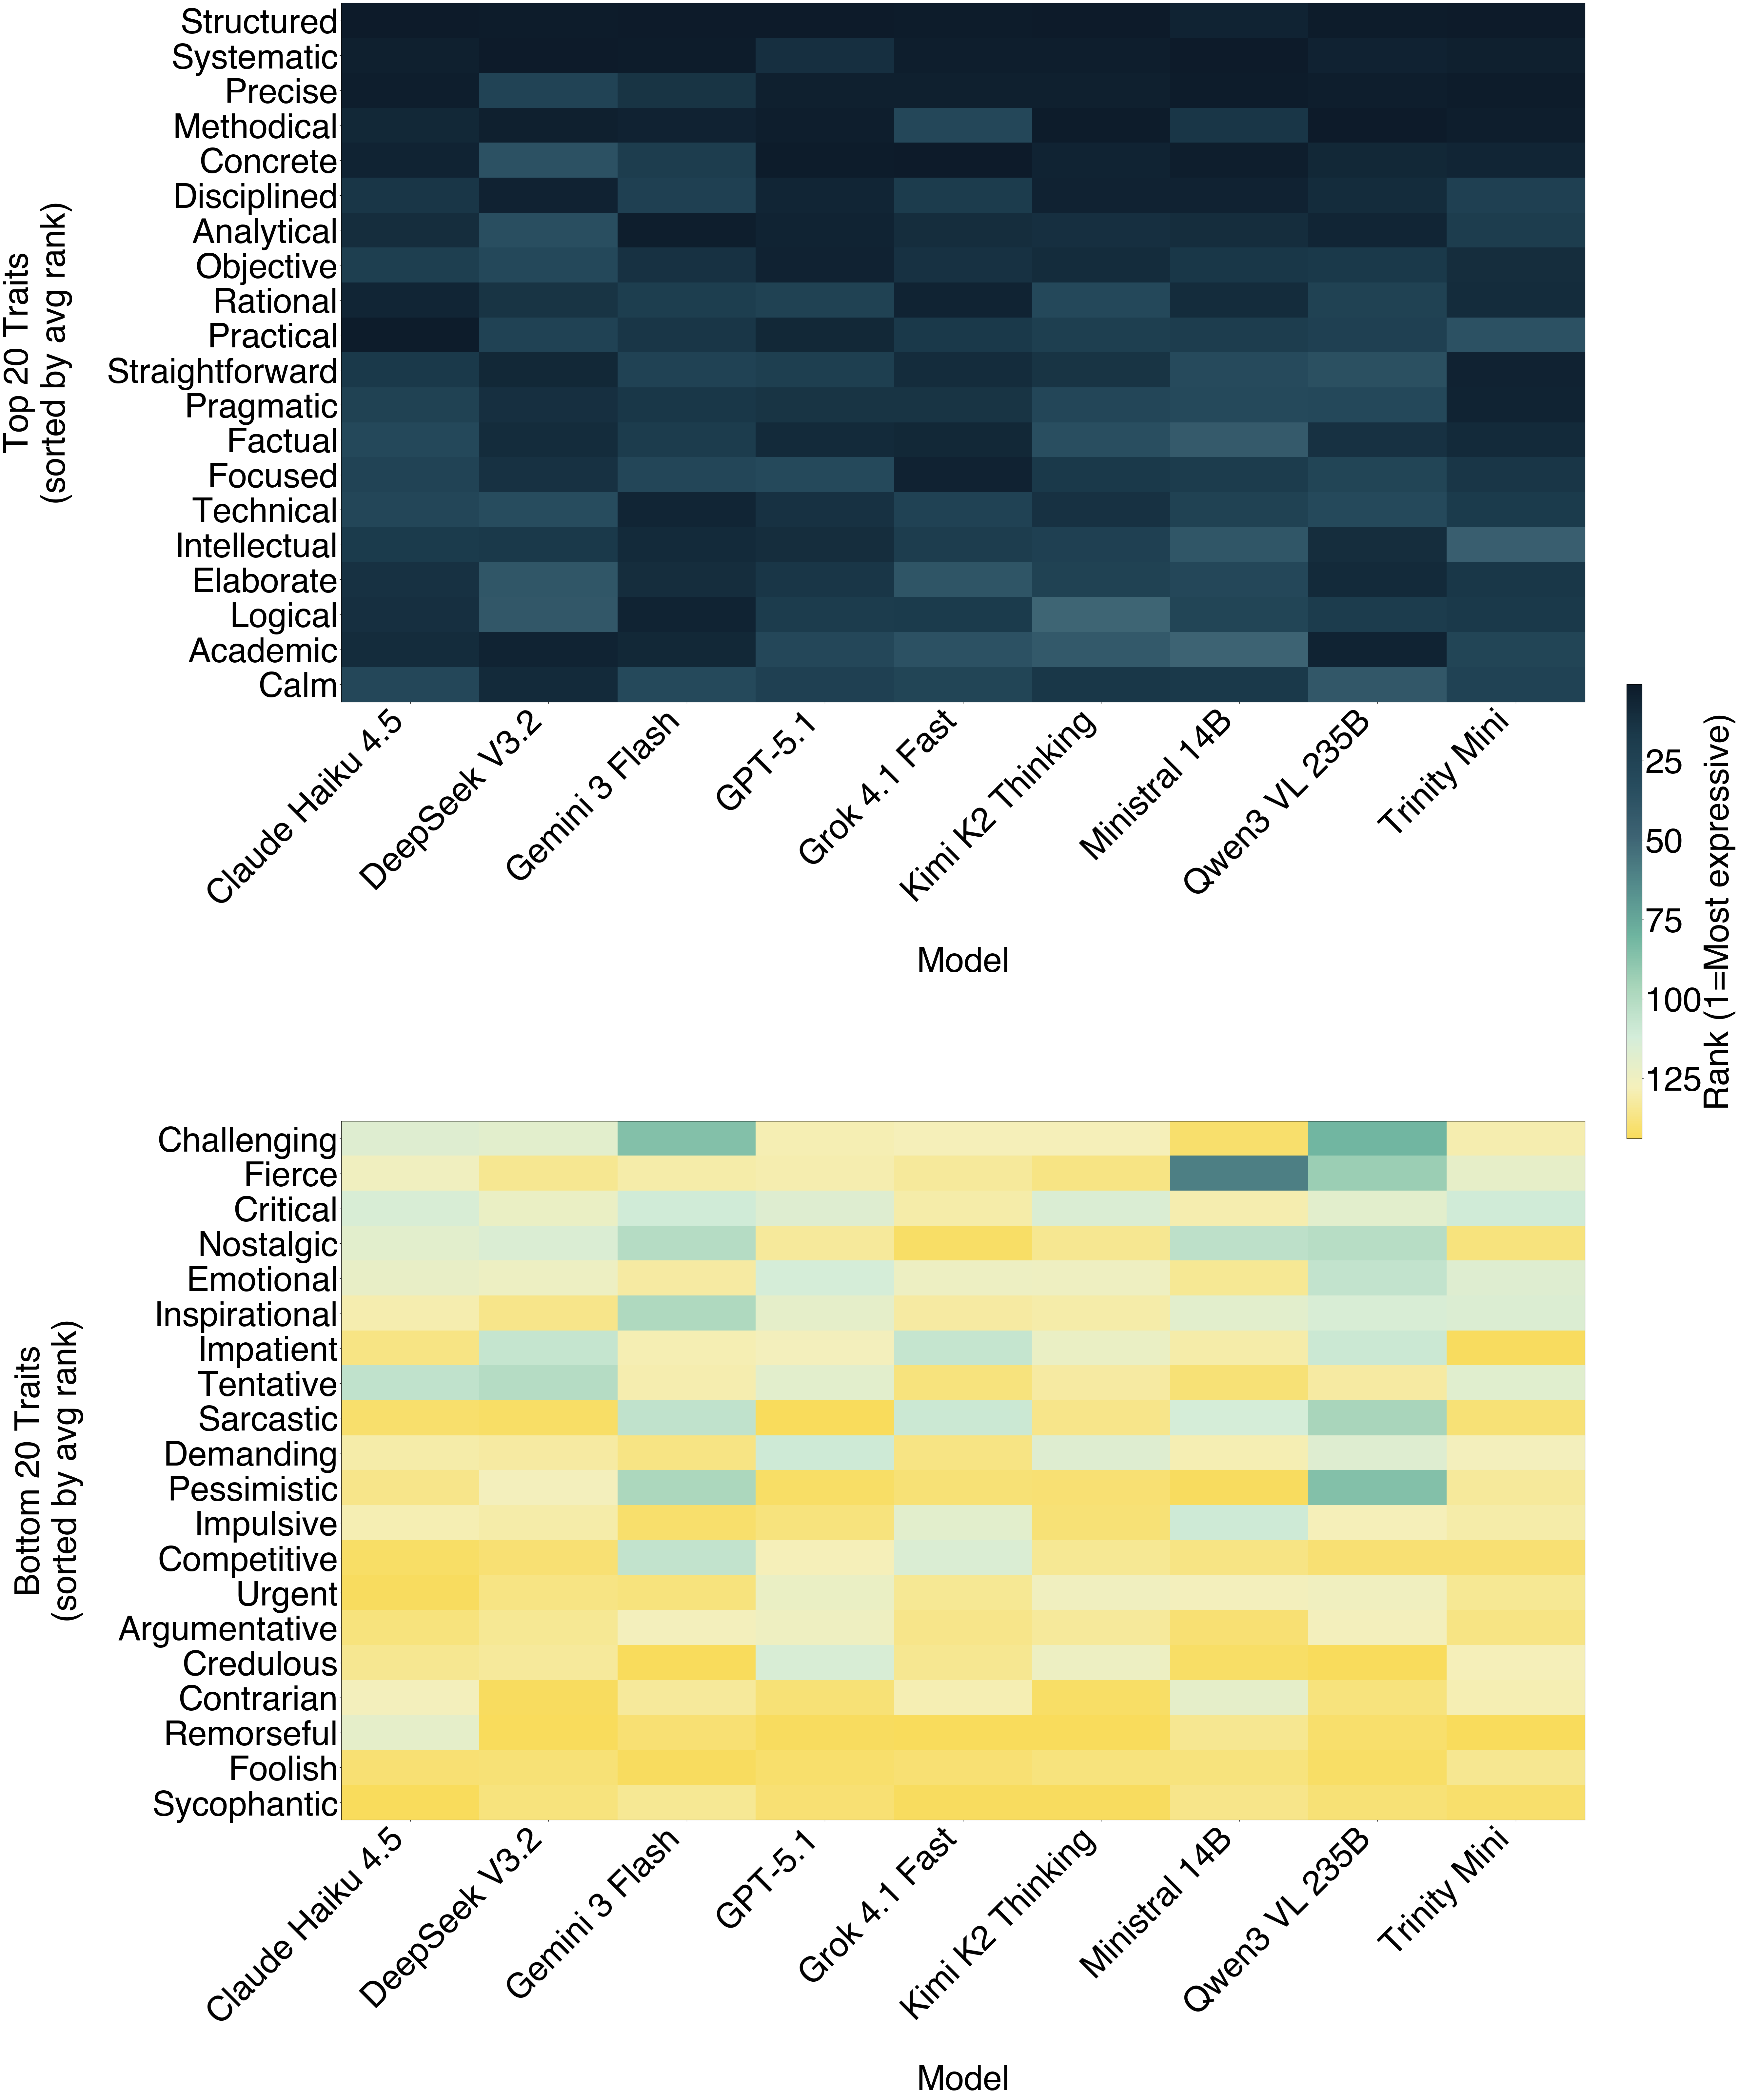

In [6]:
# =====================================================
# VISUALIZATION 4: Top & Bottom 30 Traits - Rank Heatmaps (Stacked, EXTRA-LARGE)
# Everything is scaled up 5x, with extra vertical spacing between the top/bottom plots.
# =====================================================

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# Assumed global variables:
# results, model_names, display_names

mpl.rcParams['font.family'] = 'Helvetica'

# --- FIX IS HERE ---
# constrained_layout is incompatible with tight_layout(). 
# We disable it so tight_layout(rect=...) can work below.
mpl.rcParams['figure.constrained_layout.use'] = False 
mpl.rcParams['axes.titlepad'] = 25

# Make the colorbar (legend bar) thicker horizontally
CBAR_THICKNESS = 0.2 

# Scale factors
SCALE = 5
XTICKLABEL_SIZE = 15 * SCALE
YTTICKLABEL_SIZE = 15 * SCALE
XLABEL_SIZE = 15 * SCALE
YLABEL_SIZE = 15 * SCALE
TITLE_SIZE = 15 * SCALE
LABELPAD_X = 15 * SCALE
LABELPAD_Y = 15 * SCALE
TITLEPAD = 15 * SCALE
CBAR_LABEL_SIZE = 15 * SCALE
HLINE_WIDTH = 0.5 * SCALE
CBAR_ASPECT = 6 * SCALE    
CBAR_PAD = 0.03
CBAR_FRACTION = 0.08       
TIGHTPAD = 0.81
FIG_WIDTH = 11 * SCALE
FIG_HEIGHT = 13 * SCALE + 7 

# Aliased model names
aliased_model_names = [display_names.get(m, m) for m in model_names]

# Get ALL traits
all_traits = sorted({trait for trait, _ in results[model_names[0]]})

# Calculate average rank
trait_data = {}
for trait in all_traits:
    ranks = []
    for model in valid_models:
        model_results = results[model]
        for rank, (t, _) in enumerate(model_results, 1):
            if t == trait:
                ranks.append(rank)
                break
    trait_data[trait] = {
        'avg_rank': np.mean(ranks),
        'ranks': ranks
    }

# Sort traits
sorted_all_traits = sorted(all_traits, key=lambda t: trait_data[t]['avg_rank'])

# Build rank matrix
rank_matrix = np.zeros((len(sorted_all_traits), len(model_names)))
for i, trait in enumerate(sorted_all_traits):
    rank_matrix[i, :] = trait_data[trait]['ranks']

# Indices for top/bottom
top_n = 20
top_indices = np.arange(0, top_n)
bottom_indices = np.arange(len(sorted_all_traits) - top_n, len(sorted_all_traits))

# Custom colormap
cmap = LinearSegmentedColormap.from_list(
    'rank', [
        '#0d1b2a', '#1b3a4b', '#274c5e', '#3d6373', '#548c8c',
        '#6fb5a0', '#a8d5ba', '#d4edda', '#f5f0bb', '#f9dc5c'
    ]
)

# Create subplot grid
fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1, figsize=(FIG_WIDTH, FIG_HEIGHT),
    gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.60},
    facecolor='white'
)

# --- TOP TRAITS ---
im_top = ax_top.imshow(
    rank_matrix[top_indices, :],
    cmap=cmap, aspect='auto', vmin=1, vmax=144
)

ax_top.set_xticks(range(len(model_names)))
ax_top.set_xticklabels(
    aliased_model_names,
    rotation=45, ha='right',
    fontsize=XTICKLABEL_SIZE, fontweight='bold', fontname='Helvetica'
)
ax_top.set_yticks(range(top_n))
ax_top.set_yticklabels(
    [sorted_all_traits[i].title() for i in top_indices],
    fontsize=YTTICKLABEL_SIZE, fontname='Helvetica'
)
ax_top.set_xlabel(
    'Model',
    fontsize=XLABEL_SIZE, fontweight='bold', labelpad=LABELPAD_X, fontname='Helvetica'
)
ax_top.set_ylabel(
    f'Top {top_n} Traits\n(sorted by avg rank)',
    fontsize=YLABEL_SIZE, fontweight='bold', labelpad=LABELPAD_Y, fontname='Helvetica'
)

for y in range(20, top_n, 20):
    ax_top.axhline(y - 0.5, color='white', linewidth=HLINE_WIDTH, alpha=0.6)

# --- BOTTOM TRAITS ---
im_bottom = ax_bottom.imshow(
    rank_matrix[bottom_indices, :],
    cmap=cmap, aspect='auto', vmin=1, vmax=144
)

ax_bottom.set_xticks(range(len(model_names)))
ax_bottom.set_xticklabels(
    aliased_model_names,
    rotation=45, ha='right',
    fontsize=XTICKLABEL_SIZE, fontweight='bold', fontname='Helvetica'
)
ax_bottom.set_yticks(range(top_n))
ax_bottom.set_yticklabels(
    [sorted_all_traits[i].title() for i in bottom_indices],
    fontsize=YTTICKLABEL_SIZE, fontname='Helvetica'
)
ax_bottom.set_xlabel(
    'Model',
    fontsize=XLABEL_SIZE, fontweight='bold', labelpad=LABELPAD_X, fontname='Helvetica'
)
ax_bottom.set_ylabel(
    f'Bottom {top_n} Traits\n(sorted by avg rank)',
    fontsize=YLABEL_SIZE, fontweight='bold', labelpad=LABELPAD_Y, fontname='Helvetica'
)

for y in range(20, top_n, 20):
    ax_bottom.axhline(y - 0.5, color='white', linewidth=HLINE_WIDTH, alpha=0.6)

# Colorbar
cbar = fig.colorbar(
    im_bottom, ax=[ax_top, ax_bottom],
    shrink=0.25, aspect=CBAR_ASPECT, pad=CBAR_PAD, fraction=CBAR_FRACTION
)
cbar.set_label(
    'Rank (1=Most expressive)', fontsize=CBAR_LABEL_SIZE, fontname='Helvetica'
)
cbar.ax.tick_params(labelsize=CBAR_LABEL_SIZE)
cbar.ax.invert_yaxis()

# Pass extra artists so labels aren't cut off
extra_artists = [ax_top.xaxis.label, ax_top.yaxis.label, ax_bottom.xaxis.label, ax_bottom.yaxis.label]

# TIGHT LAYOUT (Now safe to run because constrained_layout is False)
plt.tight_layout(rect=[0, 0, TIGHTPAD, 1])  

plt.savefig(
    'top_bottom_30_traits_heatmap.png',
    dpi=150,
    bbox_inches='tight',
    facecolor='white',
    bbox_extra_artists=extra_artists,
    pad_inches=0.3
)
plt.show()

In [7]:
max_len = max(len(v) for v in results.values())
results_padded = {k: v + [None] * (max_len - len(v)) for k, v in results.items()}
results_df = pd.DataFrame(results_padded)
# results_df.head(144)
results_df.head(144)

claude-haiku-4.5           deepseek-v3.2 gemini-3-flash-preview  \
0     (structured, 1395.81)   (systematic, 1324.57)  (structured, 1520.71)   
1      (practical, 1381.18)   (structured, 1287.53)  (systematic, 1510.53)   
2        (precise, 1370.22)      (literal, 1277.95)  (analytical, 1476.54)   
3     (systematic, 1369.99)   (methodical, 1268.75)   (scholarly, 1469.09)   
4    (cooperative, 1350.99)  (disciplined, 1214.29)  (methodical, 1459.51)   
..                      ...                     ...                    ...   
139       (foolish, 597.57)   (competitive, 720.14)   (remorseful, 543.03)   
140      (sarcastic, 573.7)      (humorous, 716.25)    (impulsive, 524.61)   
141   (competitive, 559.91)      (sarcastic, 714.1)     (reactive, 512.53)   
142        (urgent, 557.06)    (contrarian, 678.65)      (foolish, 410.58)   
143   (sycophantic, 522.75)    (remorseful, 663.17)    (credulous, 392.52)   

                   gpt-5.1          grok-4.1-fast        kimi-k2-thinking  \
0    (structured, 1478.04)    (concrete, 1353.68)   (structured, 1406.61)   
1      (concrete, 1422.81)  (structured, 1299.95)   (methodical, 1354.21)   
2    (methodical, 1422.65)  (systematic, 1288.14)   (systematic, 1340.89)   
3       (precise, 1400.74)     (precise, 1259.97)      (precise, 1330.48)   
4     (objective, 1380.12)     (focused, 1243.97)  (disciplined, 1315.84)   
..                     ...                    ...                     ...   
139  (sycophantic, 538.61)      (foolish, 663.78)   (pessimistic, 704.79)   
140      (foolish, 528.15)      (anxious, 643.55)      (humorous, 687.94)   
141  (pessimistic, 526.14)    (nostalgic, 641.24)    (contrarian, 663.66)   
142   (remorseful, 468.55)  (sycophantic, 620.69)   (sycophantic, 652.43)   
143    (sarcastic, 463.13)   (remorseful, 517.91)    (remorseful, 578.31)   

         ministral-14b-2512 qwen3-vl-235b-a22b-thinking  \
0     (systematic, 1247.37)       (methodical, 1339.51)   
1        (precise, 1243.68)       (structured, 1320.83)   
2       (concrete, 1238.08)          (precise, 1295.14)   
3    (specialized, 1236.84)    (authoritative, 1290.63)   
4    (disciplined, 1229.72)        (systematic, 1287.0)   
..                      ...                         ...   
139  (argumentative, 714.3)       (competitive, 709.73)   
140   (challenging, 707.63)        (remorseful, 708.62)   
141     (credulous, 699.39)           (foolish, 640.27)   
142   (pessimistic, 698.98)       (approximate, 604.26)   
143      (skeptical, 677.8)         (credulous, 576.25)   

                   trinity-mini  
0         (structured, 1369.74)  
1            (precise, 1349.53)  
2         (methodical, 1333.03)  
3          (systematic, 1311.3)  
4    (straightforward, 1289.29)  
..                          ...  
139       (competitive, 681.83)  
140       (sycophantic, 651.16)  
141          (arrogant, 641.13)  
142         (impatient, 637.32)  
143        (remorseful, 569.74)  

[144 rows x 9 columns]

In [8]:
corrs = []
for i, a in enumerate(model_names):
    for b in model_names[i+1:]:
        t1 = [trait for trait, _ in results[a]]
        t2 = [trait for trait, _ in results[b]]
        traits = sorted(set(t1) & set(t2))  # sort traits so scores are lowest to highest
        if traits:
            r1 = [rank for rank, (trait, _) in enumerate(results[a])]
            r2 = [rank for rank, (trait, _) in enumerate(results[b])]
            ranks_a = {trait: t1.index(trait) for trait in traits}
            ranks_b = {trait: t2.index(trait) for trait in traits}
            v1 = [r1[ranks_a[t]] for t in traits]
            v2 = [r2[ranks_b[t]] for t in traits]
            corr, p = spearmanr(v1, v2)
            corrs.append((corr, p, a, b))
# sort by ρ (corr) ascending
corrs_sorted = sorted(corrs, key=lambda x: x[0])
for corr, p, a, b in corrs_sorted:
    print(f"{a:35s} vs {b:35s}: \u03c1={corr:6.3f} (p={p:.2e})")

qwen3-vl-235b-a22b-thinking         vs trinity-mini                       : ρ= 0.636 (p=1.06e-17)
gpt-5.1                             vs qwen3-vl-235b-a22b-thinking        : ρ= 0.645 (p=2.87e-18)
deepseek-v3.2                       vs qwen3-vl-235b-a22b-thinking        : ρ= 0.653 (p=7.92e-19)
gemini-3-flash-preview              vs ministral-14b-2512                 : ρ= 0.674 (p=2.18e-20)
kimi-k2-thinking                    vs qwen3-vl-235b-a22b-thinking        : ρ= 0.680 (p=7.67e-21)
deepseek-v3.2                       vs ministral-14b-2512                 : ρ= 0.684 (p=3.30e-21)
grok-4.1-fast                       vs qwen3-vl-235b-a22b-thinking        : ρ= 0.684 (p=3.20e-21)
ministral-14b-2512                  vs qwen3-vl-235b-a22b-thinking        : ρ= 0.685 (p=2.95e-21)
gpt-5.1                             vs ministral-14b-2512                 : ρ= 0.690 (p=1.19e-21)
gemini-3-flash-preview              vs grok-4.1-fast                      : ρ= 0.696 (p=3.75e-22)
deepseek-v3.2       

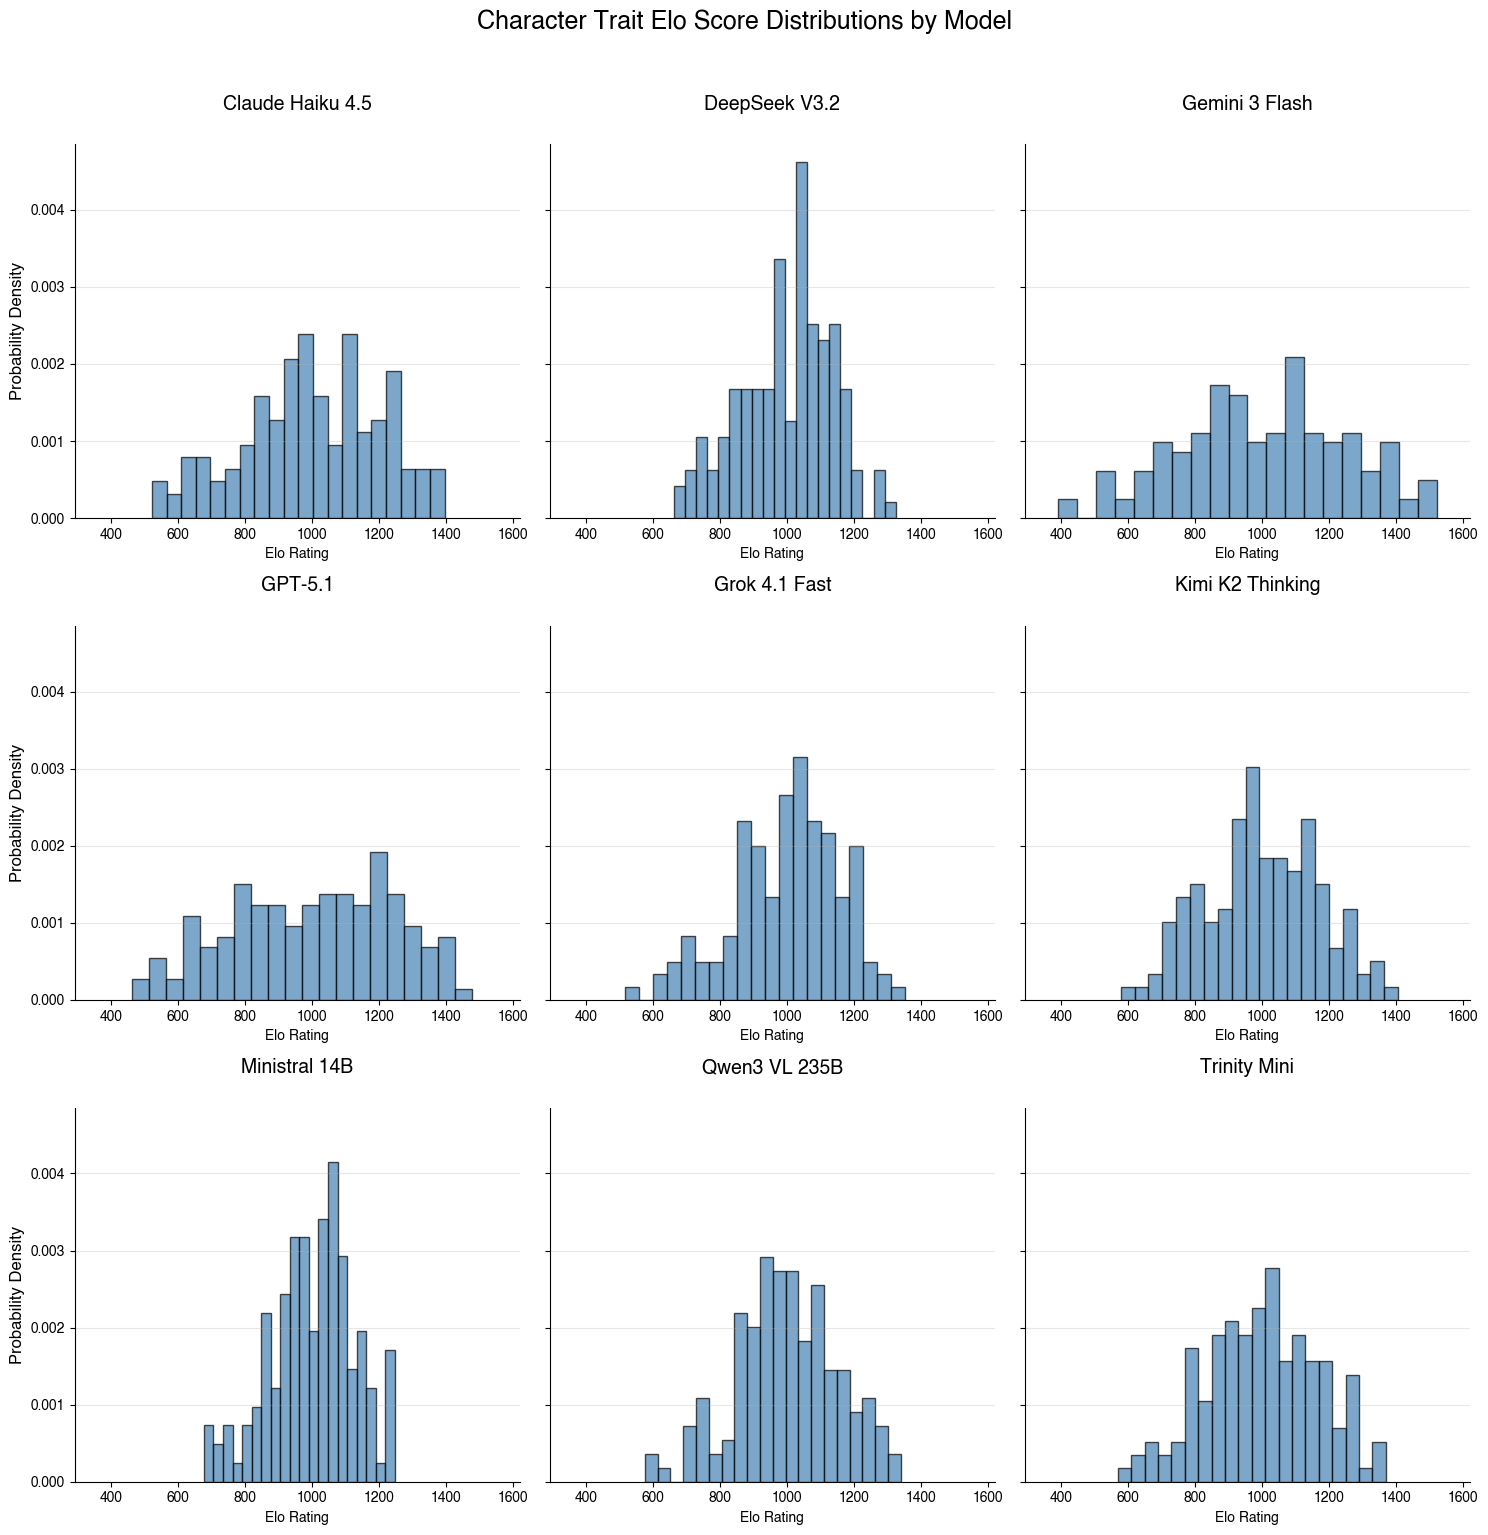

In [9]:
models_to_plot = [m for m in tested_models if m in model_names]
n_cols = 3
n_rows = (len(models_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), sharey=True)
fig.suptitle('Character Trait Elo Score Distributions by Model', fontsize=18, fontweight='bold', y=1.02)

if n_rows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

all_scores = [score for m in models_to_plot for _, score in results[m]]
x_min, x_max = min(all_scores)-100, max(all_scores)+100

for i, model in enumerate(models_to_plot):
    ax = axes_flat[i]
    scores = [score for _, score in results[model]]
    ax.hist(scores, bins=20, alpha=0.7, color='steelblue', edgecolor='black', density=True)
    ax.set_title(display_names.get(model, model), fontsize=14)
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel('Elo Rating', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for i in range(len(models_to_plot), len(axes_flat)):
    axes_flat[i].set_visible(False)

for row in range(n_rows):
    axes[row, 0].set_ylabel('Probability Density', fontsize=12)

plt.tight_layout()
plt.show()

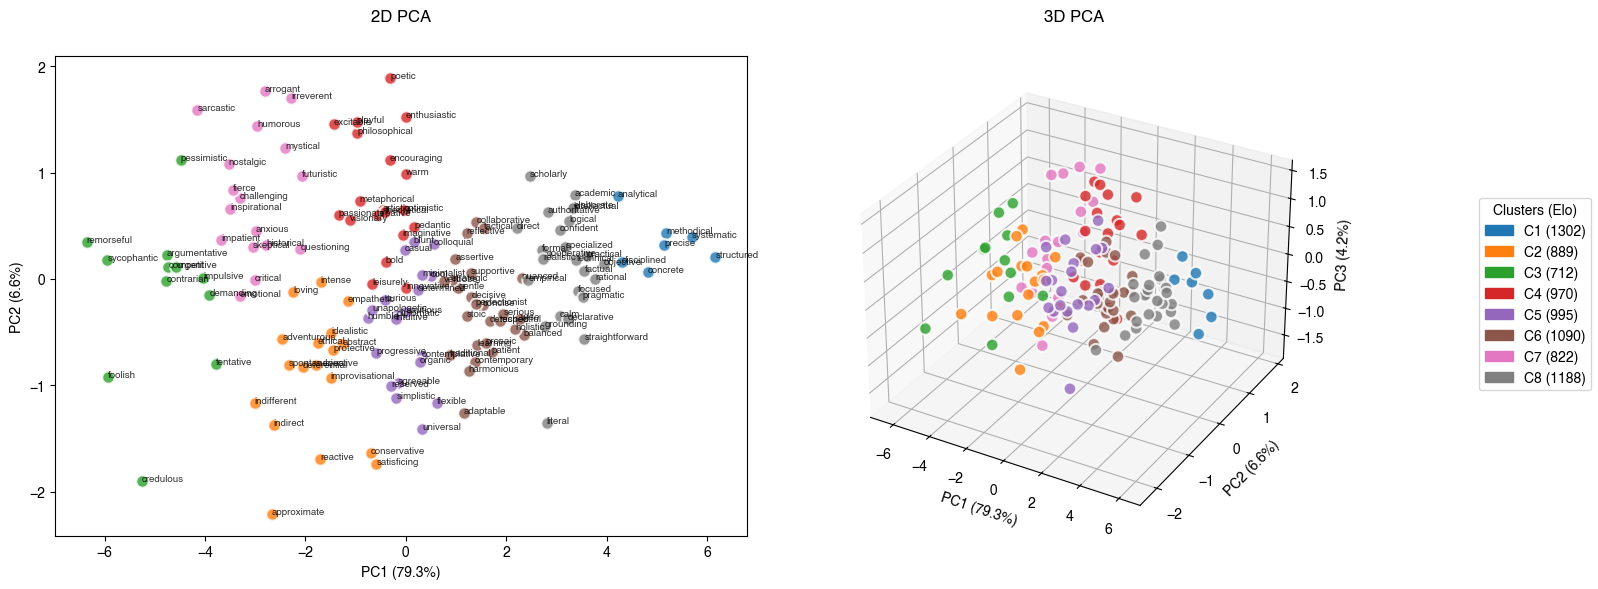

Variance explained: 2D=85.9%, 3D=90.1%


In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

elo_matrix = np.array(
    [[dict(results[m]).get(t, 1000.0) for t in all_traits] for m in valid_models]
)
elo_normalized = (elo_matrix - elo_matrix.mean(axis=1, keepdims=True)) / (elo_matrix.std(axis=1, keepdims=True) + 1e-8)

# Clustering
n_clusters = 8
clusters = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit_predict(elo_normalized.T) + 1
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
cluster_elos = {c: elo_matrix.mean(axis=0)[clusters == c].mean() for c in range(1, n_clusters + 1)}

# PCA
pca3 = PCA(n_components=3, random_state=42).fit(elo_normalized.T)
coords = pca3.transform(elo_normalized.T)

# Plot
fig = plt.figure(figsize=(16, 6))
for idx, (ndim, title) in enumerate([(2, '2D PCA'), (3, '3D PCA')]):
    ax = fig.add_subplot(1, 2, idx + 1, projection='3d' if ndim == 3 else None)
    for c in range(1, n_clusters + 1):
        mask = clusters == c
        pts = coords[mask]
        if ndim == 2:
            ax.scatter(pts[:, 0], pts[:, 1], c=colors[c-1], s=80, alpha=0.8, edgecolors='w', lw=1.5)
            for i, t in enumerate(np.array(all_traits)[mask]):
                ax.annotate(t, (pts[i, 0], pts[i, 1]), fontsize=7, alpha=0.8)
        else:
            ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=colors[c-1], s=80, alpha=0.8, edgecolors='w', lw=1.5)
    
    ax.set_xlabel(f'PC1 ({pca3.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca3.explained_variance_ratio_[1]*100:.1f}%)')
    if ndim == 3: ax.set_zlabel(f'PC3 ({pca3.explained_variance_ratio_[2]*100:.1f}%)')
    ax.set_title(title)

legend = [mpatches.Patch(color=colors[c-1], label=f'C{c} ({cluster_elos[c]:.0f})') for c in range(1, n_clusters + 1)]
fig.legend(handles=legend, loc='center right', title='Clusters (Elo)')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()
print(f'Variance explained: 2D={sum(pca3.explained_variance_ratio_[:2])*100:.1f}%, 3D={sum(pca3.explained_variance_ratio_)*100:.1f}%')

In [11]:
top_traits = trait_stats.head(12)['trait'].tolist()

# Redefine groups according to new specification
group1 = [m for m in [
    "gemini-3-flash-preview", 
    "grok-4.1-fast", 
    "ministral-14b-2512", 
    "qwen3-vl-235b-a22b-thinking"
] if m in valid_models]
group2 = [m for m in valid_models if m not in group1]

model_groups = [("Gemini/Grok/Ministral/Qwen", group1),
                ("Other Selected Benchmark Models", group2)]

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#A0BC3E', '#B25AE4', "#F18BA1", '#008080']

for group_name, compare_models in model_groups:
    radar_data = {}
    for model in compare_models:
        scores = [dict(results[model]).get(t, 1000) for t in top_traits]
        min_s, max_s = min(scores), max(scores)
        radar_data[model] = [(s - min_s) / (max_s - min_s) if max_s > min_s else 0.5 for s in scores]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    N = len(top_traits)
    angles = [n / N * 2 * np.pi for n in range(N)] + [0]

    for i, model in enumerate(compare_models):
        values = radar_data[model] + radar_data[model][:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=display_names.get(model, model),
                color=colors[i % len(colors)])
        ax.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(top_traits, fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_title(f'Relative Preference for Top 12 Traits\n({group_name})', fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel('Normalized Score', fontsize=10, labelpad=30)
    ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.05), title='Model')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

: 

Global Elo range: 392.52 - 1520.71
Mean trait value across all plotted models: 0.5384554567301563


/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/2813655288.py:150: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(raw_labels, fontsize=40, color='grey', fontname='Helvetica')


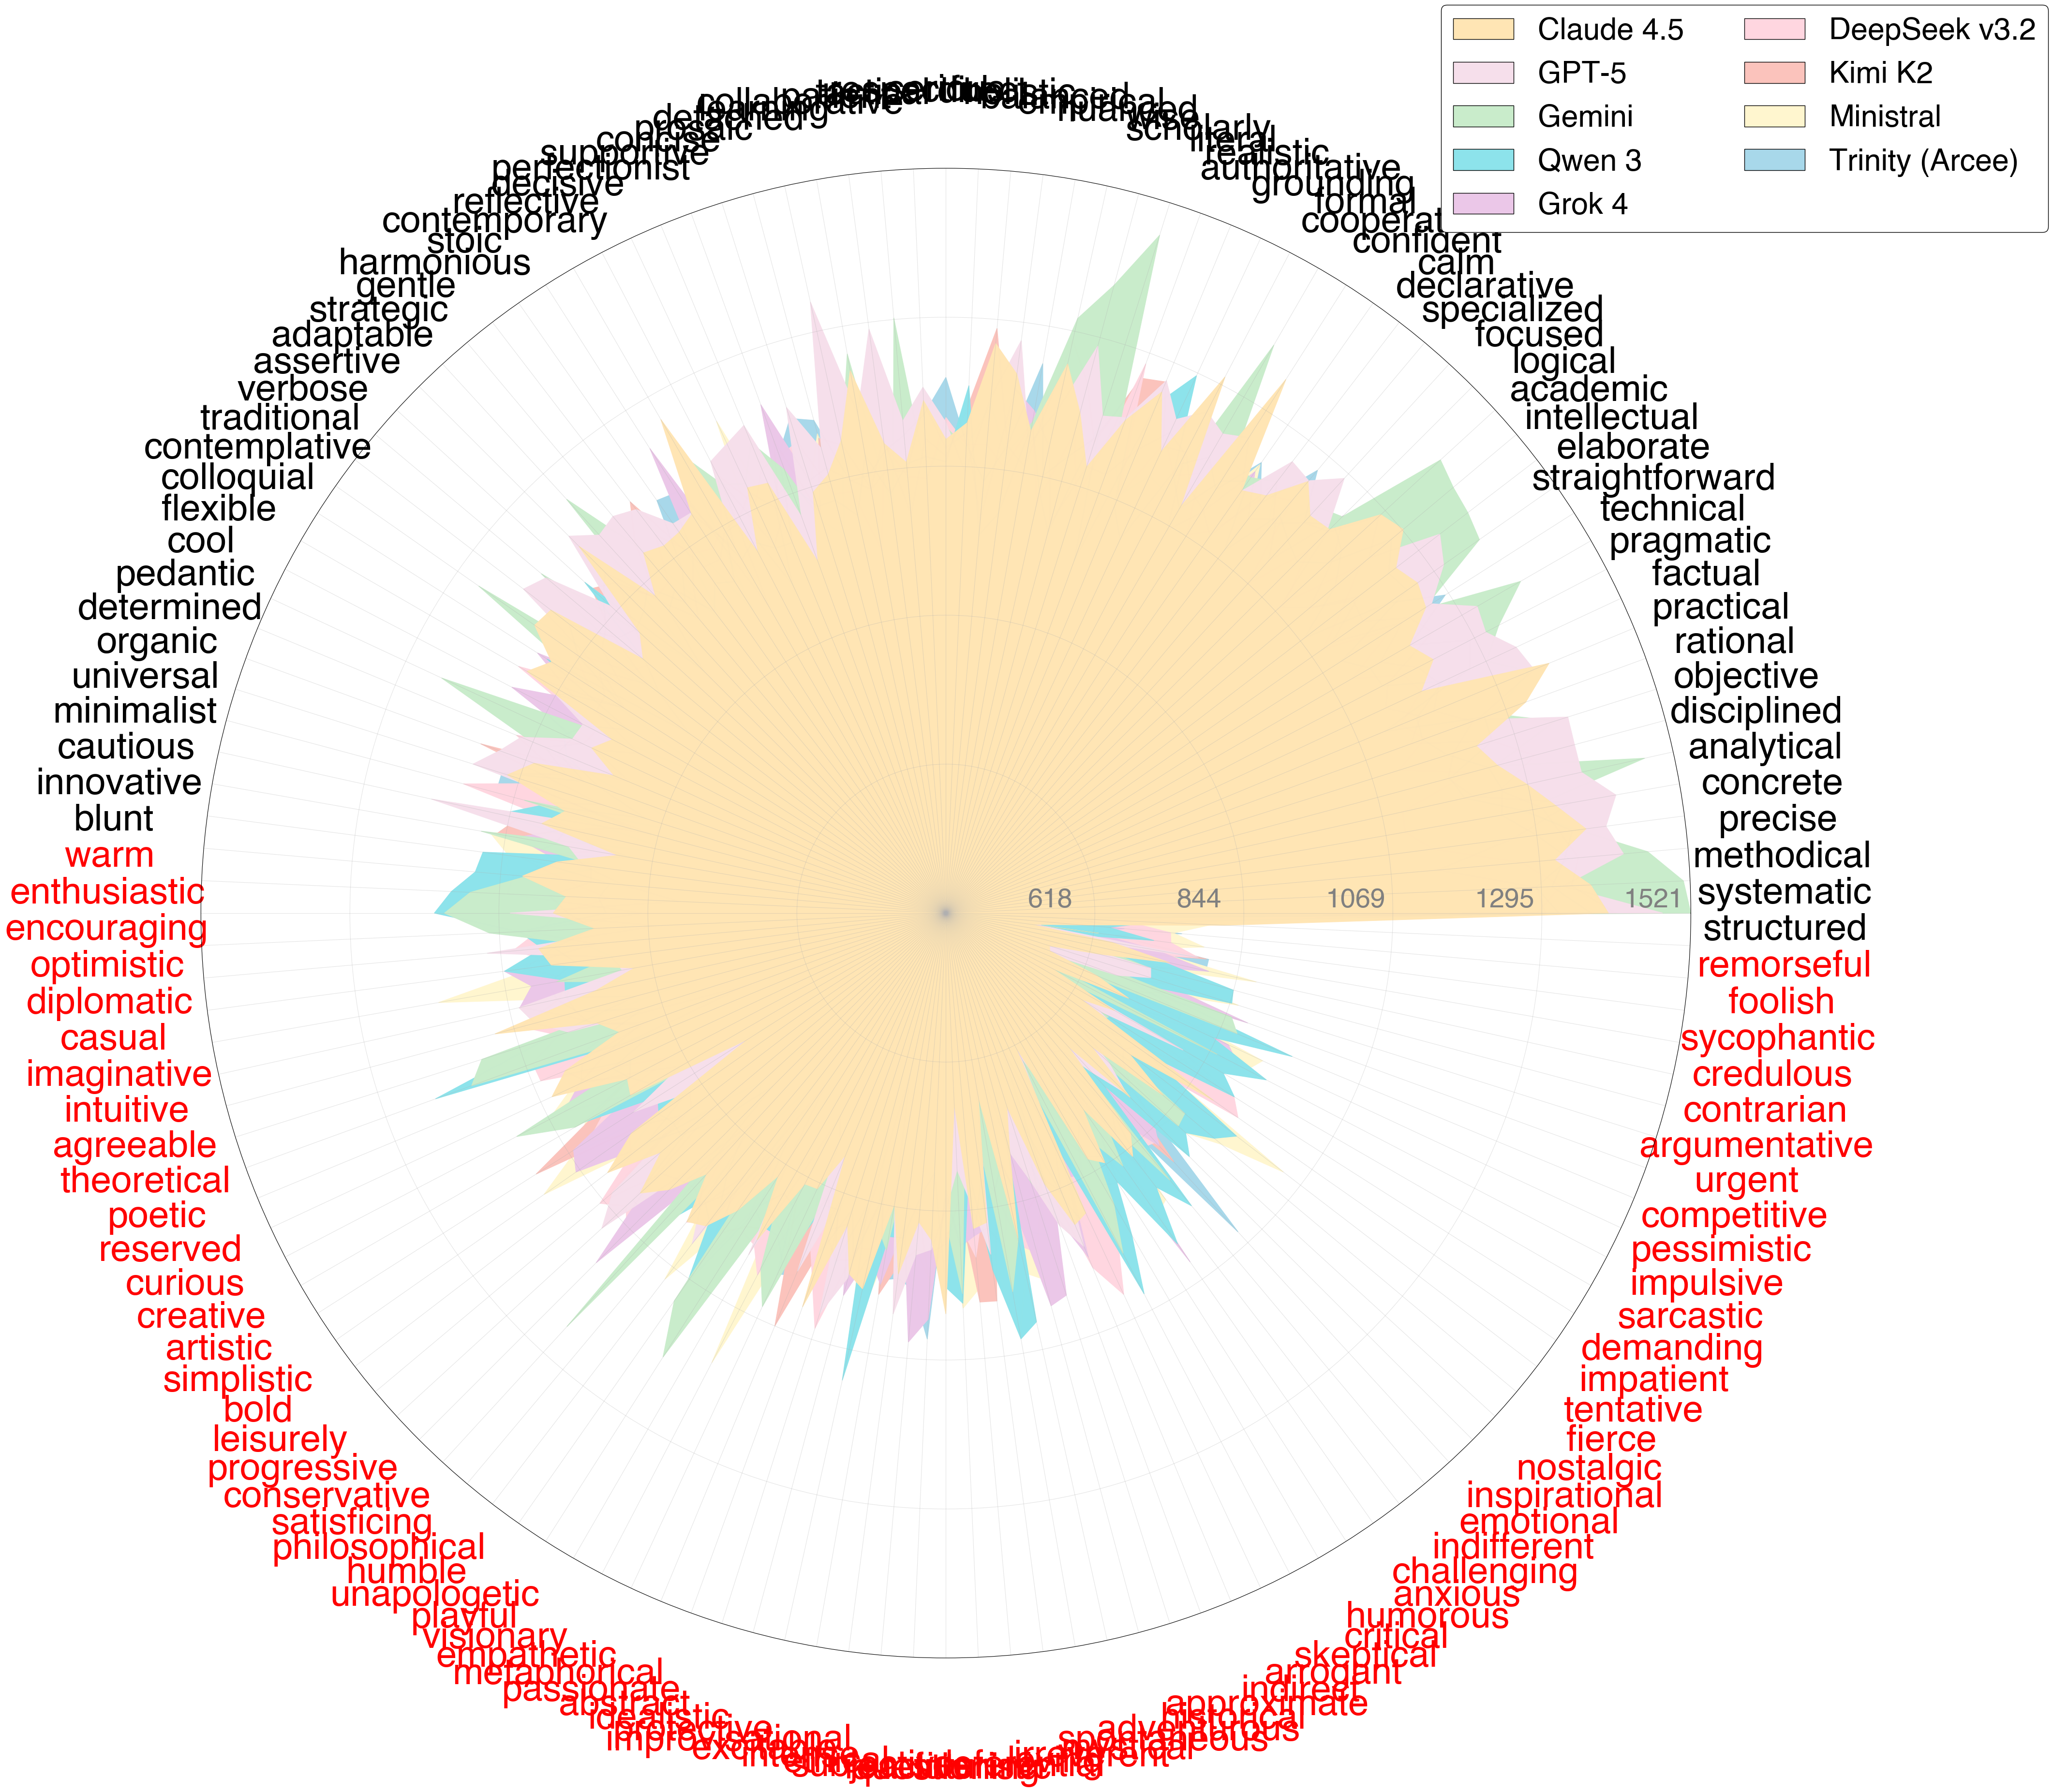

In [18]:
# Plot a radar ("spider") chart for all traits—literally every one—but label *only* key traits
import matplotlib

# Set default font globally for all matplotlib plots
matplotlib.rcParams['font.family'] = 'Helvetica'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'

# Define specific model order (top of legend = top layer visually)
models_to_plot = [
    "claude-haiku-4.5",
    "gpt-5.1",
    "gemini-3-flash-preview",
    "qwen3-vl-235b-a22b-thinking",
    "grok-4.1-fast",
    "deepseek-v3.2",
    "kimi-k2-thinking",
    "ministral-14b-2512",
    "trinity-mini",
]
# Filter to only include models that exist in valid_models
models_to_plot = [m for m in models_to_plot if m in valid_models]

# Override display names to show company names
display_names = {
    "claude-haiku-4.5": "Claude 4.5",
    "gpt-5.1": "GPT-5",
    "gemini-3-flash-preview": "Gemini",
    "qwen3-vl-235b-a22b-thinking": "Qwen 3",
    "grok-4.1-fast": "Grok 4",
    "deepseek-v3.2": "DeepSeek v3.2",
    "kimi-k2-thinking": "Kimi K2",
    "ministral-14b-2512": "Ministral",
    "trinity-mini": "Trinity (Arcee)",
}

# Label every Nth trait
label_every_n = 1

from itertools import cycle
color_cycle = cycle([
    "#FFE5B4",
    "#F6DFEB",
    "#C9ECCB",
    "#8DE3EB",
    "#EBC7E8",
    "#FFD6E0",
    "#FBC3BC",
    "#FFF6CF",
    "#A8D8EA",
])

# Prepare normalized radar data [0-1] for all models using GLOBAL normalization
# This ensures positions are directly comparable across models

# Sort all_traits by average ELO across all models (greatest to least)
trait_avg_elo = {}
for trait in all_traits:
    elos = [dict(results[model]).get(trait, 1000) for model in models_to_plot]
    trait_avg_elo[trait] = np.mean(elos)
all_traits_sorted = sorted(all_traits, key=lambda t: trait_avg_elo[t], reverse=True)

# First, collect ALL scores across all models to find true global min/max
all_scores = []
radar_data_raw = {}
for model in models_to_plot:
    scores = [dict(results[model]).get(t, 1000) for t in all_traits_sorted]
    radar_data_raw[model] = scores
    all_scores.extend(scores)

global_min, global_max = min(all_scores), max(all_scores)
print(f"Global Elo range: {global_min:.2f} - {global_max:.2f}")

# Now normalize all models using the same global scale
radar_data = {}
for model in models_to_plot:
    scores = radar_data_raw[model]
    radar_data[model] = [(s - global_min) / (global_max - global_min) for s in scores]

fig, ax = plt.subplots(figsize=(40, 40), subplot_kw=dict(polar=True))
N = len(all_traits_sorted)
angles = [n / N * 2 * np.pi for n in range(N)] + [0]

color_map = {model: next(color_cycle) for model in models_to_plot}

# Plot in REVERSE order so first items in legend appear on TOP (rendered last)
for model in reversed(models_to_plot):
    values = radar_data[model] + radar_data[model][:1]
    ax.plot(
        angles, values, linewidth=2, label=display_names.get(model, model),
        color=color_map[model], alpha=0.01
    )
    ax.fill(angles, values, alpha=1, color=color_map[model])

# Calculate mean normalized trait value across all plotted models, for the midpoint threshold
mean_val_overall = np.mean([np.mean(radar_data[model]) for model in models_to_plot])
midpoint = mean_val_overall

# Now, determine labels and which ones to highlight based on mean across models for that trait and new midpoint
# Pick evenly spaced indices to label
num_labels = len(all_traits_sorted) // label_every_n
labeled_indices = set(np.linspace(0, len(all_traits_sorted) - 1, num_labels, dtype=int))

trait_labels = []
trait_label_colors = []
for idx, t in enumerate(all_traits_sorted):
    if idx in labeled_indices:
        trait_labels.append(t)
        mean_val = np.mean([radar_data[model][idx] for model in models_to_plot])
        if mean_val < midpoint:
            trait_label_colors.append("red")
        else:
            trait_label_colors.append("black")
    else:
        trait_labels.append("")
        trait_label_colors.append(None)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(trait_labels, fontsize=55, fontname='Helvetica')

# Color the tick labels and rotate the labeled ones only
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text():
        label.set_rotation(90)
        label.set_ha('center')
        label.set_va('top')
        color = trait_label_colors[i]
        if color is not None:
            label.set_color(color)
        label.set_fontname("Helvetica")
ax.tick_params(axis='x', pad=130)

# ------------------------------------------------------------------------
# Customize the radial (score) tickmarks:
# 1. Make font size 30,
# 2. Make tick/label color grey,
# 3. Place the radial labels on the left (theta=180 deg).

# Use global_min and global_max already calculated above for consistent labeling
r_ticks = ax.get_yticks()
raw_labels = []
for norm_val in r_ticks:
    raw_val = norm_val * (global_max - global_min) + global_min
    # For prettiness, round raw scores; use int for Elo <= 2000, 2 decimal otherwise
    if (global_max - global_min) < 4:
        raw_labels.append(f"{raw_val:.2f}")
    else:
        raw_labels.append(f"{int(round(raw_val))}")

# Set the radial labels and style them
ax.set_yticklabels(raw_labels, fontsize=40, color='grey', fontname='Helvetica')

# Move radial tick labels to the left (theta=180 deg, i.e., 'left')
ax.yaxis.set_tick_params(labelleft=True, labelright=False)
ax.set_rlabel_position(0)

# Shift radial labels horizontally to the left
from matplotlib.transforms import ScaledTranslation
dx, dy = -100/72, 0  # -15 points to the left (adjust as needed)
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.yaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offset)
    label.set_fontname("Helvetica")

ax.set_ylim(0, 1)
legend_ncol = 2 if len(models_to_plot) > 6 else 1
from matplotlib.patches import Patch
legend_handles = [
    Patch(
        facecolor=color_map[model],
        edgecolor='black',
        alpha=1,
        label=display_names.get(model, model)  # <-- Add model names here
    )
    for model in models_to_plot
]
legend = ax.legend(
    handles=legend_handles,
    loc='upper right',
    bbox_to_anchor=(1.25, 1.12),  # Adjust x to move right
    fontsize=45,
    ncol=legend_ncol,
    framealpha=1,
    facecolor='white',
    edgecolor='black'
)
# Set legend font to Helvetica
for text in legend.get_texts():
    text.set_fontname("Helvetica")

print("Mean trait value across all plotted models:", mean_val_overall)

ax.grid(alpha=0.33)
# Removed tight_layout() - it interferes with legend positioning on polar plots
plt.show()

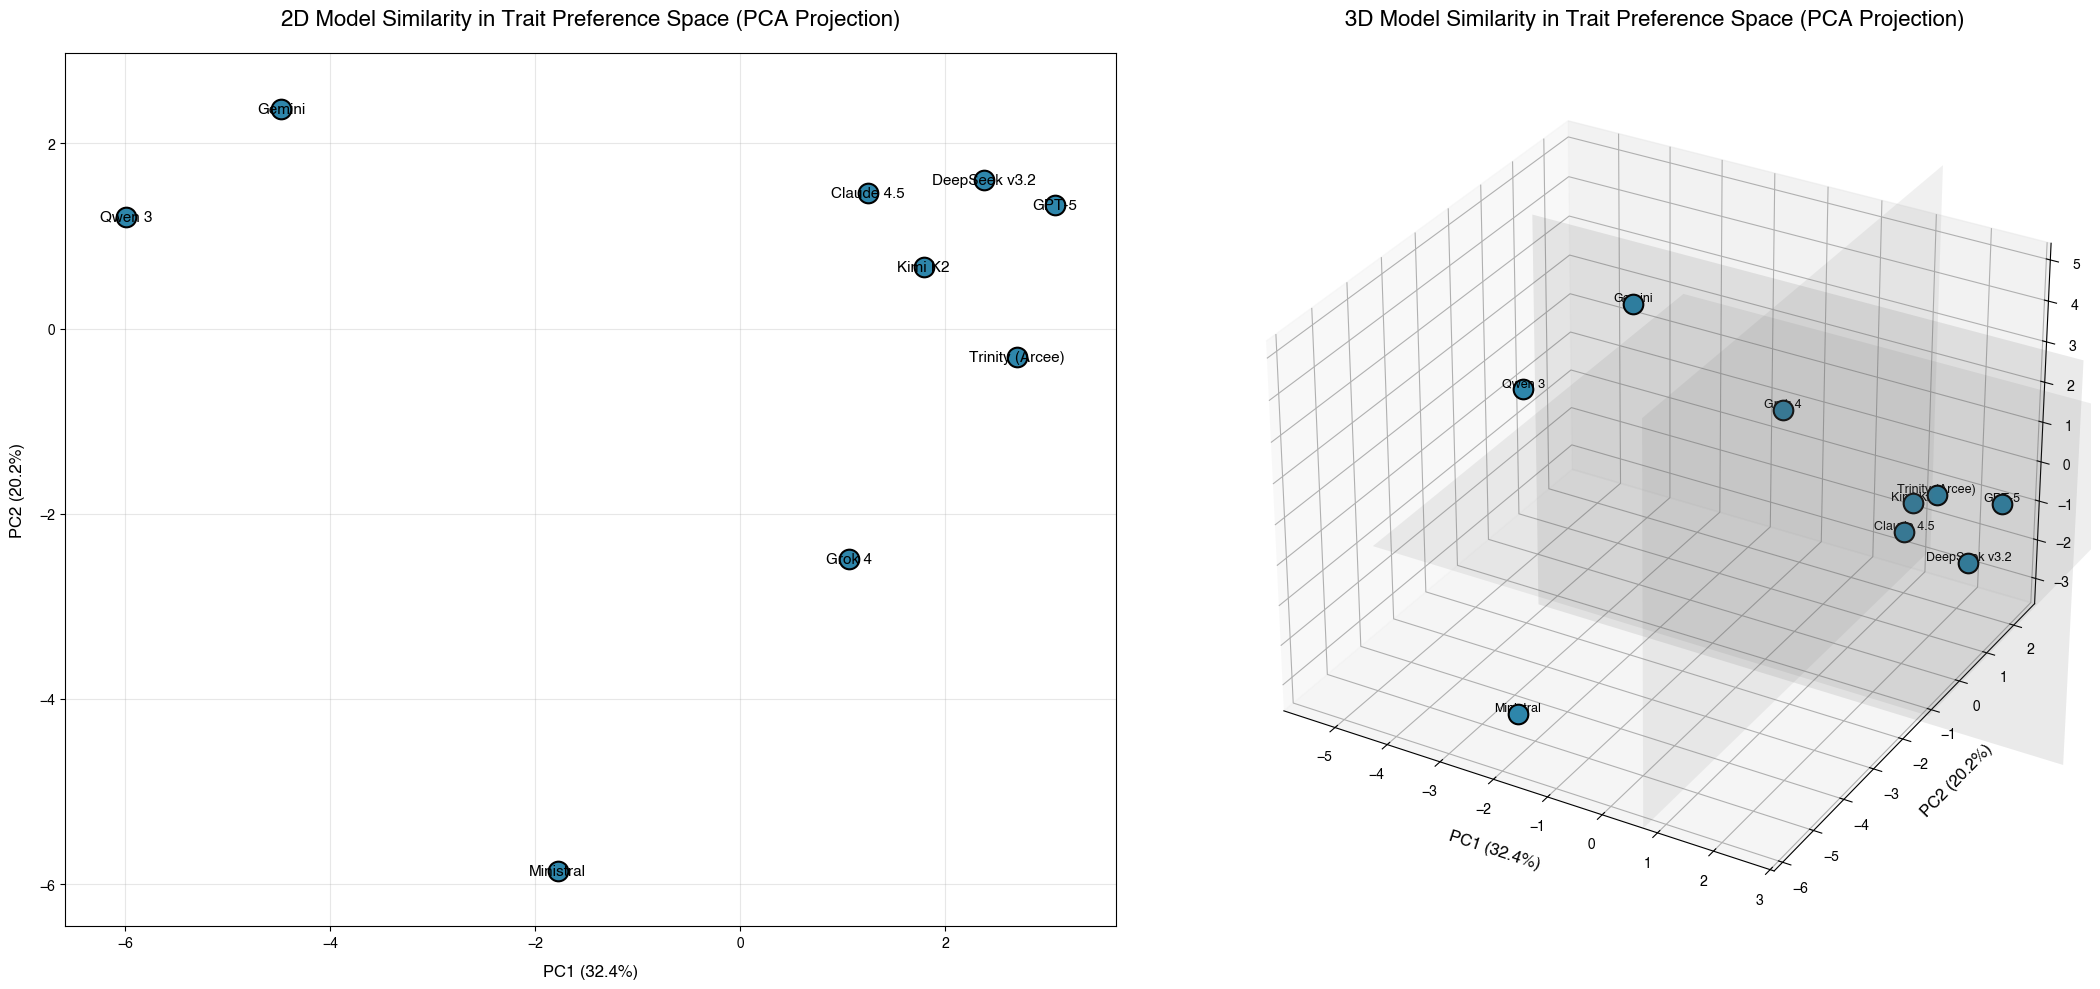

Total variance explained by 3 components: 64.2%
Additional variance explained by PC3: 11.6%

Top trait loadings per principal component:

PC1 (32.4% variance):
  approximate          (loading: +0.223)
  poetic               (loading: -0.204)
  arrogant             (loading: -0.204)
  irreverent           (loading: -0.194)
  sarcastic            (loading: -0.191)
  satisficing          (loading: +0.183)

PC2 (20.2% variance):
  skeptical            (loading: +0.227)
  contemplative        (loading: +0.217)
  imaginative          (loading: -0.195)
  challenging          (loading: +0.190)
  encouraging          (loading: +0.188)
  bold                 (loading: -0.181)

PC3 (11.6% variance):
  competitive          (loading: +0.231)
  nostalgic            (loading: -0.215)
  anxious              (loading: -0.214)
  remorseful           (loading: -0.197)
  humorous             (loading: +0.196)
  unapologetic         (loading: -0.186)


In [23]:
# 3D PCA Analysis: Model Preference Similarity & Trait Loadings (plus 2D plot)

from mpl_toolkits.mplot3d import Axes3D

# 2D PCA for models in trait space
pca_2d = PCA(n_components=2)
model_pca_2d = pca_2d.fit_transform(elo_normalized)

# 3D PCA for models in trait space
pca_3d = PCA(n_components=3)
model_pca_3d = pca_3d.fit_transform(elo_normalized)

# Plot 2D + 3D side by side
fig = plt.figure(figsize=(22, 10))

# --- 2D PCA subplot (left) ---
ax2d = fig.add_subplot(1, 2, 1)
model_color = '#2E86AB'
model_marker = 'o'

for i, model in enumerate(valid_models):
    ax2d.scatter(model_pca_2d[i, 0], model_pca_2d[i, 1], 
                 s=200, c=model_color, marker=model_marker, edgecolors='black', linewidths=1.5, zorder=3)
    ax2d.text(model_pca_2d[i, 0], model_pca_2d[i, 1], 
              display_names.get(model, model), fontsize=11, fontweight='bold',
              ha='center', va='center')

ax2d.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12, fontweight='bold', labelpad=10)
ax2d.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12, fontweight='bold', labelpad=10)
ax2d.set_title('2D Model Similarity in Trait Preference Space (PCA Projection)', fontsize=16, fontweight='bold', pad=20)
ax2d.grid(alpha=0.30)
# Keep aspect and ranges reasonable
buffer_2d = 0.1 * np.abs(model_pca_2d).max()
ax2d.set_xlim(model_pca_2d[:, 0].min() - buffer_2d, model_pca_2d[:, 0].max() + buffer_2d)
ax2d.set_ylim(model_pca_2d[:, 1].min() - buffer_2d, model_pca_2d[:, 1].max() + buffer_2d)

# --- 3D PCA subplot (right) ---
ax = fig.add_subplot(1, 2, 2, projection='3d')

for i, model in enumerate(valid_models):
    ax.scatter(model_pca_3d[i, 0], model_pca_3d[i, 1], model_pca_3d[i, 2], 
               s=200, c=model_color, marker=model_marker, edgecolors='black', linewidths=1.5, zorder=3)
    ax.text(model_pca_3d[i, 0], model_pca_3d[i, 1], model_pca_3d[i, 2], 
            display_names.get(model, model), fontsize=9, fontweight='bold',
            ha='center', va='bottom')

# Reference planes (for better sense of 3D orientation)
ax.plot_surface(np.array([[-5, 5], [-5, 5]]), np.array([[-5, -5], [5, 5]]), 
                np.zeros((2, 2)), alpha=0.1, color='gray')
ax.plot_surface(np.zeros((2, 2)), np.array([[-5, -5], [5, 5]]), 
                np.array([[-5, 5], [-5, 5]]), alpha=0.1, color='gray')
ax.plot_surface(np.array([[-5, -5], [5, 5]]), np.zeros((2, 2)), 
                np.array([[-5, 5], [-5, 5]]), alpha=0.1, color='gray')

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)', fontsize=12, fontweight='bold', labelpad=10)
ax.set_title('3D Model Similarity in Trait Preference Space (PCA Projection)', fontsize=16, fontweight='bold', pad=20)

# Set equal aspect ratio for 3D
max_range = np.array([model_pca_3d[:, 0].max() - model_pca_3d[:, 0].min(),
                      model_pca_3d[:, 1].max() - model_pca_3d[:, 1].min(),
                      model_pca_3d[:, 2].max() - model_pca_3d[:, 2].min()]).max() / 2.0
mid_x = (model_pca_3d[:, 0].max() + model_pca_3d[:, 0].min()) * 0.5
mid_y = (model_pca_3d[:, 1].max() + model_pca_3d[:, 1].min()) * 0.5
mid_z = (model_pca_3d[:, 2].max() + model_pca_3d[:, 2].min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.tight_layout()
plt.show()

total_var_3d = sum(pca_3d.explained_variance_ratio_) * 100
print(f"Total variance explained by 3 components: {total_var_3d:.1f}%")
print(f"Additional variance explained by PC3: {pca_3d.explained_variance_ratio_[2]*100:.1f}%\n")

# Print top contributing traits (loadings) for each principal component
n_loadings = 6
feature_names = trait_stats['trait'].tolist() if hasattr(trait_stats, 'trait') else [f'Trait {i}' for i in range(elo_normalized.shape[1])]

components = pca_3d.components_
print("Top trait loadings per principal component:")
for idx, comp in enumerate(components):
    sorted_idx = np.argsort(np.abs(comp))[::-1]
    print(f"\nPC{idx+1} ({pca_3d.explained_variance_ratio_[idx]*100:.1f}% variance):")
    for j in range(n_loadings):
        trait = feature_names[sorted_idx[j]]
        value = comp[sorted_idx[j]]
        print(f"  {trait:20s} (loading: {value:+.3f})")

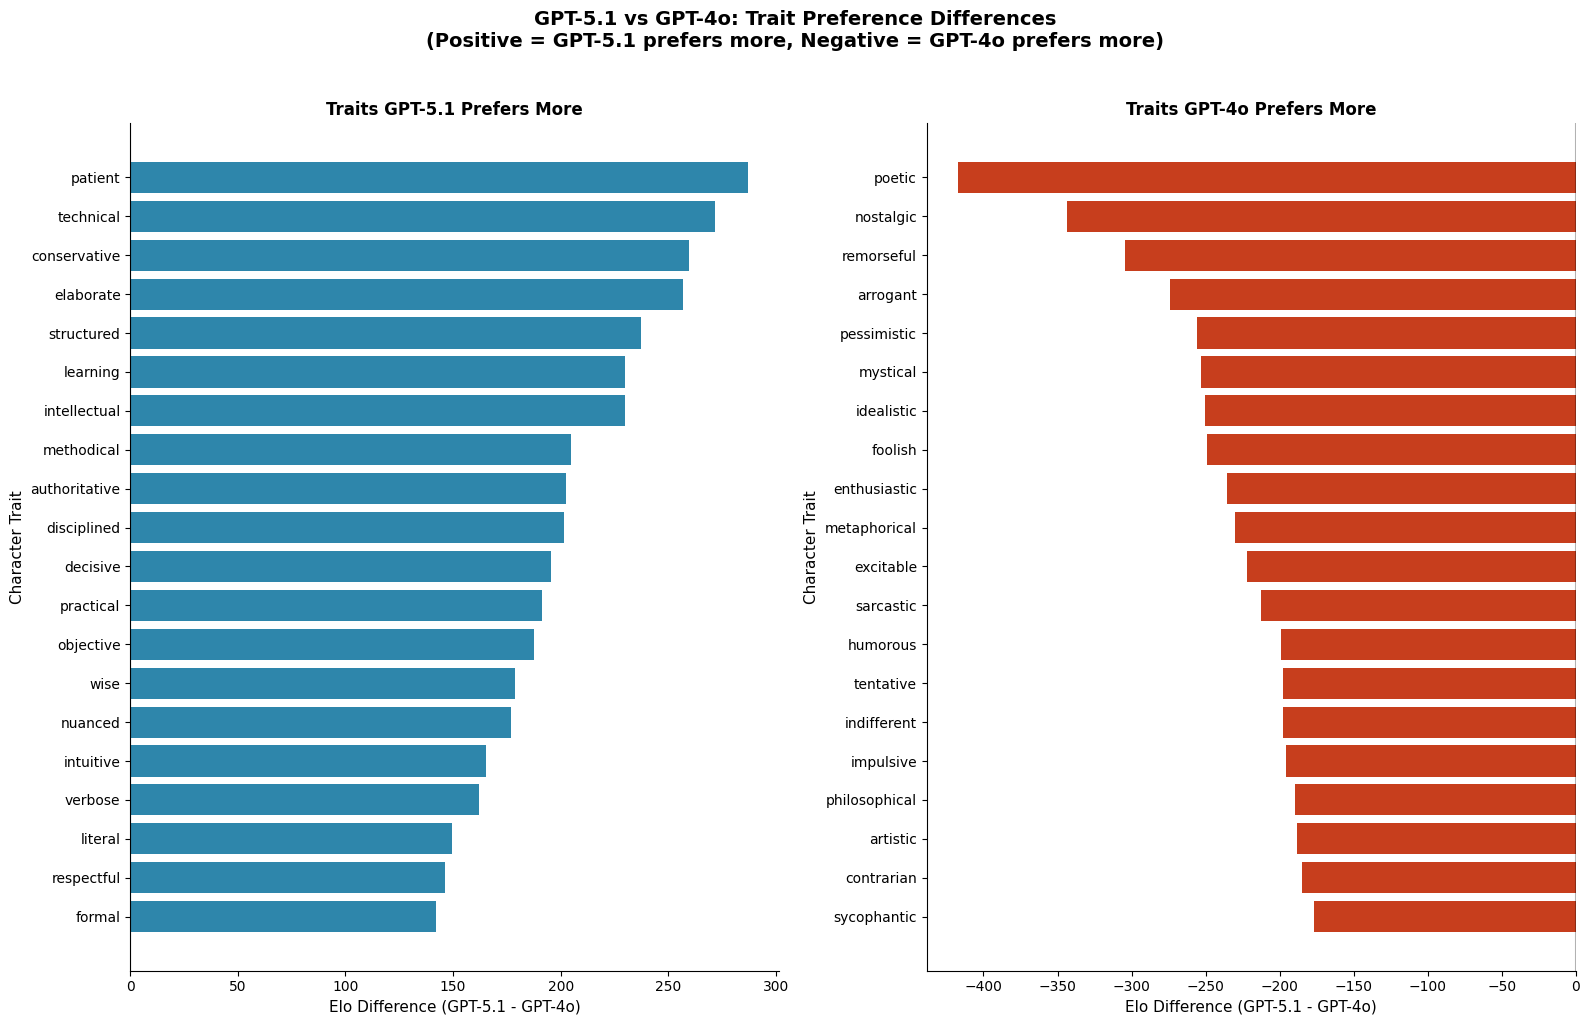


Correlation between GPT-5.1 and GPT-4o trait preferences: 0.832


In [ ]:
# GPT-5.1 vs GPT-4o Comparison
gpt51_elo = dict(results["gpt-5.1"])
gpt4o_elo = dict(results["gpt-4o"])

# Compute differences
gpt_diff = []
for trait in all_traits:
    diff = gpt51_elo.get(trait, 1000) - gpt4o_elo.get(trait, 1000)
    gpt_diff.append((trait, diff, gpt51_elo.get(trait, 1000), gpt4o_elo.get(trait, 1000)))

gpt_diff_sorted = sorted(gpt_diff, key=lambda x: x[1], reverse=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
fig.suptitle('GPT-5.1 vs GPT-4o: Trait Preference Differences\n(Positive = GPT-5.1 prefers more, Negative = GPT-4o prefers more)', 
             fontsize=14, fontweight='bold', y=1.02)

n_show = 20

# Traits GPT-5.1 prefers more
top_51 = gpt_diff_sorted[:n_show]
traits_51 = [x[0] for x in top_51]
diffs_51 = [x[1] for x in top_51]
axes[0].barh(range(n_show), diffs_51, color='#2E86AB')
axes[0].set_yticks(range(n_show))
axes[0].set_yticklabels(traits_51, fontsize=10)
axes[0].invert_yaxis()
axes[0].set_xlabel('Elo Difference (GPT-5.1 - GPT-4o)', fontsize=11)
axes[0].set_ylabel('Character Trait', fontsize=11)
axes[0].set_title('Traits GPT-5.1 Prefers More', fontsize=12, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Traits GPT-4o prefers more
top_4o = gpt_diff_sorted[-n_show:][::-1]
traits_4o = [x[0] for x in top_4o]
diffs_4o = [x[1] for x in top_4o]
axes[1].barh(range(n_show), diffs_4o, color='#C73E1D')
axes[1].set_yticks(range(n_show))
axes[1].set_yticklabels(traits_4o, fontsize=10)
axes[1].invert_yaxis()
axes[1].set_xlabel('Elo Difference (GPT-5.1 - GPT-4o)', fontsize=11)
axes[1].set_ylabel('Character Trait', fontsize=11)
axes[1].set_title('Traits GPT-4o Prefers More', fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Print summary stats
corr_51_4o = np.corrcoef(
    [gpt51_elo[t] for t in all_traits],
    [gpt4o_elo[t] for t in all_traits]
)[0, 1]
print(f"\nCorrelation between GPT-5.1 and GPT-4o trait preferences: {corr_51_4o:.3f}")

/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_84459/2957866732.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=8)
/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_84459/2957866732.py:92: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=8)


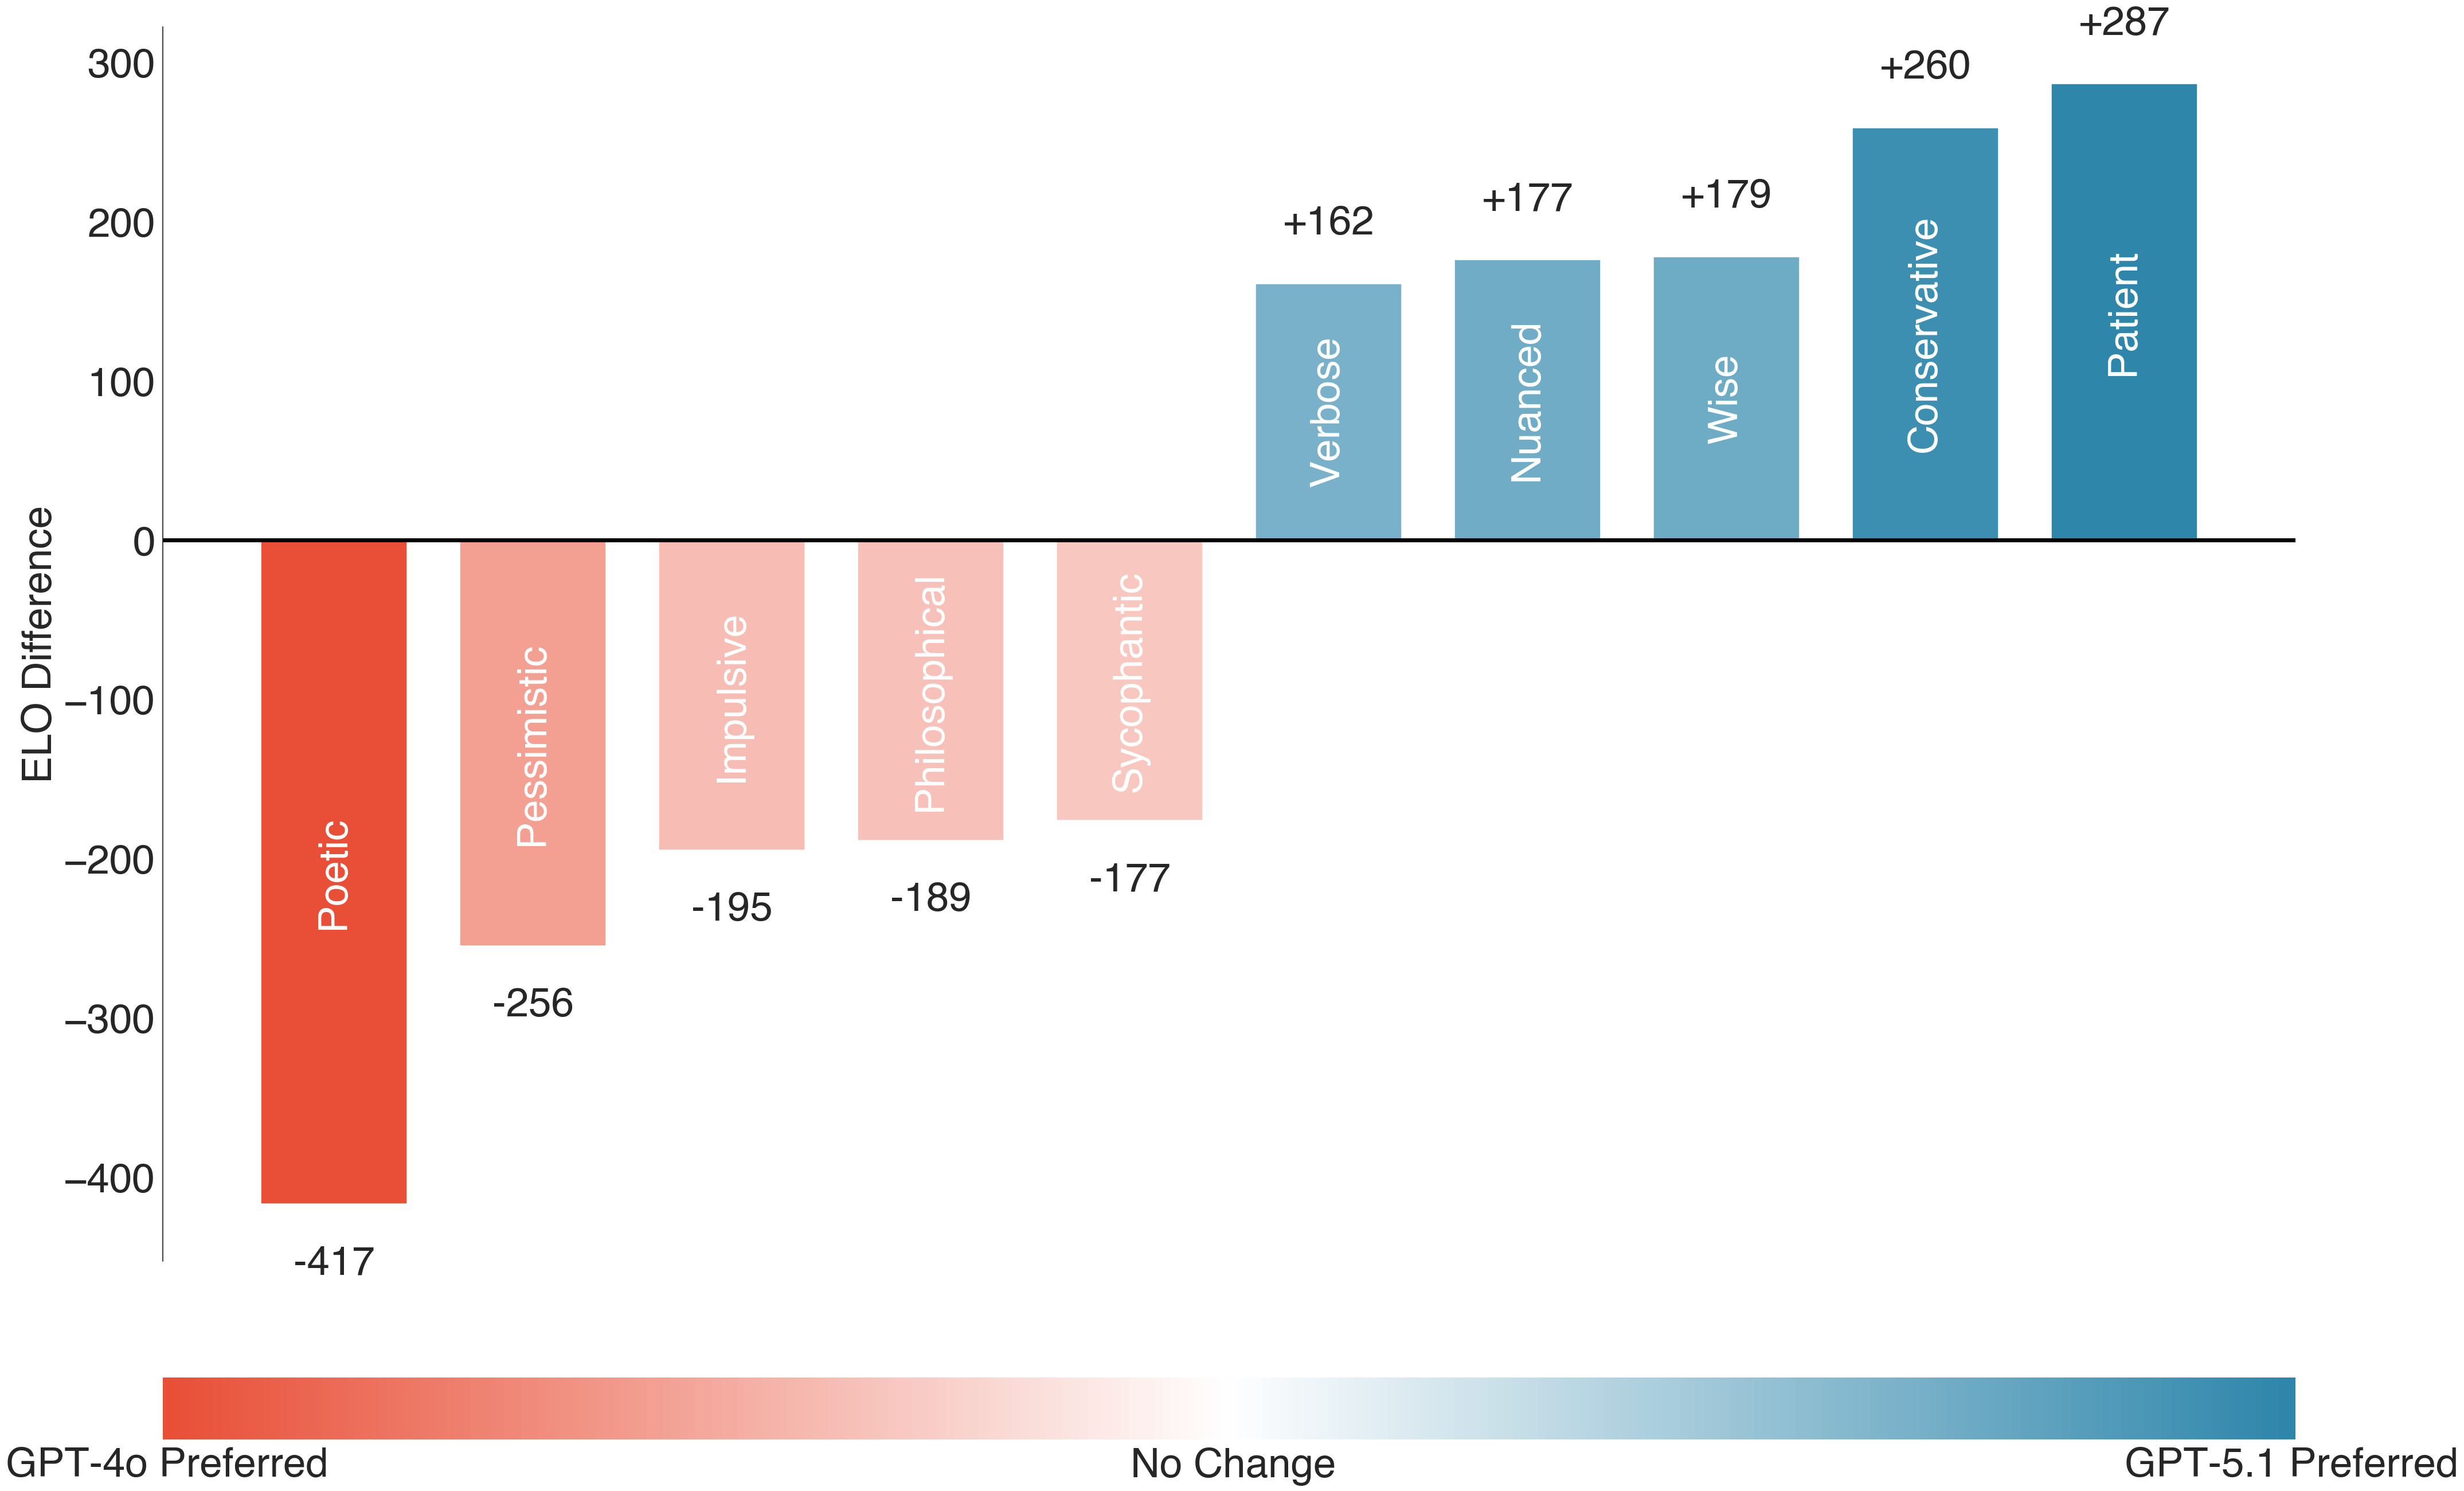

In [ ]:
# GPT-4o vs GPT-5.1 Trait Preference Comparison

plt.rcParams['font.family'] = 'Helvetica'

# Get ELO dicts for both models
gpt4o_elo = dict(results["gpt-4o"])
gpt51_elo = dict(results["gpt-5.1"])

# Traits and their categories (ordered by difference for visual flow)
gpt4o_prefers = ["poetic", "sycophantic", "philosophical", "impulsive", "pessimistic"]
gpt51_prefers = ["patient", "conservative", "nuanced", "verbose", "wise"]

# Calculate differences and sort
all_traits = gpt4o_prefers + gpt51_prefers
trait_diffs = []
for trait in all_traits:
    diff = gpt51_elo.get(trait, 1000) - gpt4o_elo.get(trait, 1000)
    trait_diffs.append((trait.capitalize(), diff))

# Sort by difference (most negative to most positive)
trait_diffs.sort(key=lambda x: x[1])
labels, differences = zip(*trait_diffs)

# Normalize differences to 0-1 for colormap
diff_min, diff_max = min(differences), max(differences)
norm_diffs = [(d - diff_min) / (diff_max - diff_min) for d in differences]

# Create custom colormap (orange -> white -> blue)
from matplotlib.colors import LinearSegmentedColormap
colors_list = ['#E94F37', '#FFFFFF', '#2E86AB']
cmap = LinearSegmentedColormap.from_list('gpt_cmap', colors_list)

# -- Add a bit of space between bars --

n_bars = len(labels)
gap = 0.22  # Increased gap for a noticeable space
bar_width = 0.65  # Slightly reduced width for more visual space

# x positions: add a bit of space between bars
total_bar_area = n_bars * bar_width + (n_bars - 1) * gap
x_start = 0
x_pos = [x_start + i * (bar_width + gap) for i in range(n_bars)]

# Create figure with space for gradient bar (4x resolution)
fig, (ax_main, ax_cbar) = plt.subplots(
    2, 1,
    figsize=(48, 32),  # quadrupled from (24, 16)
    gridspec_kw={'height_ratios': [20, 1], 'hspace': 0.18}
)

# Bar colors from gradient
bar_colors = [cmap(n) for n in norm_diffs]

# Plot vertical bar chart with a bit of space between bars
bars = ax_main.bar(x_pos, differences, color=bar_colors, width=bar_width, edgecolor='white', linewidth=4.0)

# Add trait labels inside bars
for bar, label, diff in zip(bars, labels, differences):
    y_text = diff / 2
    color = 'white' if abs(diff)  > 50 else 'black'
    ax_main.text(bar.get_x() + bar.get_width()/2, y_text, label,
                 ha='center', va='center', fontsize=51, fontweight='bold',
                 color=color, rotation=90)

# Styling
ax_main.axhline(y=0, color='black', linewidth=5.0)
ax_main.set_ylabel('ELO Difference', fontsize=51)
ax_main.set_xticks([])
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)
ax_main.spines['bottom'].set_visible(False)
ax_main.tick_params(axis='y', labelsize=51)

# Add ELO difference values above/below bars
for bar, diff in zip(bars, differences):
    y_pos = diff + (25 if diff >= 0 else -25)
    va = 'bottom' if diff >= 0 else 'top'
    ax_main.text(bar.get_x() + bar.get_width()/2, y_pos, f'{diff:+.0f}',
                 ha='center', va=va, fontsize=51, fontweight='bold')

# Simple gradient colorbar
gradient = np.linspace(0, 1, 256).reshape(1, -1)
ax_cbar.imshow(gradient, aspect='auto', cmap=cmap)
ax_cbar.set_yticks([])
ax_cbar.set_xticks([0, 128, 255])
ax_cbar.set_xticklabels(['GPT-4o Preferred', 'No Change', 'GPT-5.1 Preferred'], fontsize=51)
ax_cbar.spines['top'].set_visible(False)
ax_cbar.spines['right'].set_visible(False)
ax_cbar.spines['bottom'].set_visible(False)
ax_cbar.spines['left'].set_visible(False)

plt.tight_layout(pad=8)

# Save as SVG before showing
fig.savefig("gpt4o_vs_gpt51_trait_diff.svg", format="svg", bbox_inches="tight")

plt.show()

In [25]:
# =============================================================================
# SEMANTIC CLUSTER ANALYSIS: Model Preferences by Trait Categories
# =============================================================================
# Instead of data-driven PCA, this analysis groups the 144 traits into 18 
# semantically meaningful clusters to understand model personality profiles.

# Define 18 semantic clusters
cluster_names = [
    "Emotional Warmth & Care", "Energy & Intensity", "Calmness & Composure", 
    "Pace & Urgency", "Communication Directness", "Communication Formality",
    "Verbosity & Density", "Figurative vs Literal Language", "Humor & Tone",
    "Social Cooperation vs Competition", "Confidence & Assertiveness", 
    "Analytical vs Intuitive Reasoning", "Skepticism & Critical Thinking",
    "Intellectual vs Practical Focus", "Structure & Flexibility", 
    "Precision & Standards", "Outlook & Optimism", "Creativity & Openness to Change"
]

# Trait to cluster mapping
trait_to_cluster = {
    "remorseful": "Emotional Warmth & Care", "diplomatic": "Social Cooperation vs Competition",
    "deferential": "Confidence & Assertiveness", "idealistic": "Outlook & Optimism",
    "rational": "Analytical vs Intuitive Reasoning", "poetic": "Figurative vs Literal Language",
    "serious": "Humor & Tone", "excitable": "Energy & Intensity",
    "warm": "Emotional Warmth & Care", "agreeable": "Social Cooperation vs Competition",
    "contrarian": "Skepticism & Critical Thinking", "blunt": "Communication Directness",
    "traditional": "Creativity & Openness to Change", "focused": "Structure & Flexibility",
    "perfectionist": "Precision & Standards", "specialized": "Intellectual vs Practical Focus",
    "impulsive": "Pace & Urgency", "enthusiastic": "Energy & Intensity",
    "structured": "Structure & Flexibility", "bold": "Confidence & Assertiveness",
    "reflective": "Calmness & Composure", "approximate": "Precision & Standards",
    "critical": "Skepticism & Critical Thinking", "confident": "Confidence & Assertiveness",
    "indirect": "Communication Directness", "optimistic": "Outlook & Optimism",
    "challenging": "Skepticism & Critical Thinking", "logical": "Analytical vs Intuitive Reasoning",
    "casual": "Communication Formality", "disciplined": "Structure & Flexibility",
    "prosaic": "Figurative vs Literal Language", "balanced": "Calmness & Composure",
    "irreverent": "Humor & Tone", "objective": "Analytical vs Intuitive Reasoning",
    "cooperative": "Social Cooperation vs Competition", "satisficing": "Precision & Standards",
    "unapologetic": "Confidence & Assertiveness", "direct": "Communication Directness",
    "minimalist": "Verbosity & Density", "flexible": "Structure & Flexibility",
    "colloquial": "Communication Formality", "encouraging": "Emotional Warmth & Care",
    "skeptical": "Skepticism & Critical Thinking", "reserved": "Energy & Intensity",
    "pedantic": "Precision & Standards", "adaptable": "Structure & Flexibility",
    "intellectual": "Intellectual vs Practical Focus", "spontaneous": "Pace & Urgency",
    "detached": "Emotional Warmth & Care", "empirical": "Analytical vs Intuitive Reasoning",
    "metaphorical": "Figurative vs Literal Language", "collaborative": "Social Cooperation vs Competition",
    "strategic": "Analytical vs Intuitive Reasoning", "determined": "Energy & Intensity",
    "passionate": "Energy & Intensity", "progressive": "Creativity & Openness to Change",
    "tactical": "Analytical vs Intuitive Reasoning", "cautious": "Pace & Urgency",
    "philosophical": "Intellectual vs Practical Focus", "universal": "Intellectual vs Practical Focus",
    "stoic": "Calmness & Composure", "anxious": "Calmness & Composure",
    "fierce": "Energy & Intensity", "reactive": "Pace & Urgency",
    "factual": "Figurative vs Literal Language", "urgent": "Pace & Urgency",
    "nostalgic": "Creativity & Openness to Change", "authoritative": "Confidence & Assertiveness",
    "pragmatic": "Intellectual vs Practical Focus", "contemporary": "Creativity & Openness to Change",
    "leisurely": "Pace & Urgency", "argumentative": "Social Cooperation vs Competition",
    "realistic": "Outlook & Optimism", "technical": "Intellectual vs Practical Focus",
    "wise": "Analytical vs Intuitive Reasoning", "systematic": "Structure & Flexibility",
    "methodical": "Structure & Flexibility", "intuitive": "Analytical vs Intuitive Reasoning",
    "arrogant": "Confidence & Assertiveness", "decisive": "Confidence & Assertiveness",
    "academic": "Communication Formality", "formal": "Communication Formality",
    "impatient": "Pace & Urgency", "intense": "Energy & Intensity",
    "futuristic": "Creativity & Openness to Change", "cool": "Calmness & Composure",
    "humble": "Confidence & Assertiveness", "grounding": "Calmness & Composure",
    "creative": "Creativity & Openness to Change", "supportive": "Emotional Warmth & Care",
    "imaginative": "Creativity & Openness to Change", "scholarly": "Communication Formality",
    "simplistic": "Precision & Standards", "innovative": "Creativity & Openness to Change",
    "concrete": "Intellectual vs Practical Focus", "practical": "Intellectual vs Practical Focus",
    "protective": "Emotional Warmth & Care", "analytical": "Analytical vs Intuitive Reasoning",
    "declarative": "Communication Directness", "tentative": "Confidence & Assertiveness",
    "pessimistic": "Outlook & Optimism", "empathetic": "Emotional Warmth & Care",
    "curious": "Creativity & Openness to Change", "sycophantic": "Social Cooperation vs Competition",
    "mystical": "Figurative vs Literal Language", "historical": "Creativity & Openness to Change",
    "loving": "Emotional Warmth & Care", "straightforward": "Communication Directness",
    "precise": "Precision & Standards", "calm": "Calmness & Composure",
    "improvisational": "Structure & Flexibility", "nuanced": "Precision & Standards",
    "demanding": "Precision & Standards", "inspirational": "Outlook & Optimism",
    "conservative": "Creativity & Openness to Change", "artistic": "Creativity & Openness to Change",
    "elaborate": "Verbosity & Density", "indifferent": "Emotional Warmth & Care",
    "theoretical": "Intellectual vs Practical Focus", "respectful": "Social Cooperation vs Competition",
    "foolish": "Analytical vs Intuitive Reasoning", "assertive": "Confidence & Assertiveness",
    "verbose": "Verbosity & Density", "visionary": "Creativity & Openness to Change",
    "adventurous": "Creativity & Openness to Change", "questioning": "Skepticism & Critical Thinking",
    "gentle": "Emotional Warmth & Care", "literal": "Figurative vs Literal Language",
    "sarcastic": "Humor & Tone", "playful": "Humor & Tone",
    "humorous": "Humor & Tone", "organic": "Structure & Flexibility",
    "abstract": "Intellectual vs Practical Focus", "patient": "Pace & Urgency",
    "credulous": "Skepticism & Critical Thinking", "emotional": "Energy & Intensity",
    "concise": "Verbosity & Density", "holistic": "Intellectual vs Practical Focus",
    "ethical": "Emotional Warmth & Care", "contemplative": "Calmness & Composure",
    "subjective": "Analytical vs Intuitive Reasoning", "learning": "Creativity & Openness to Change",
    "competitive": "Social Cooperation vs Competition", "harmonious": "Social Cooperation vs Competition"
}

# Invert: cluster -> list of traits
cluster_to_traits = {c: [] for c in cluster_names}
for trait, cluster in trait_to_cluster.items():
    cluster_to_traits[cluster].append(trait)

# Verify counts
print("Traits per cluster:")
for cluster in cluster_names:
    print(f"  {cluster}: {len(cluster_to_traits[cluster])} traits")
print(f"\nTotal traits mapped: {len(trait_to_cluster)}")

# Build cluster ELO matrix: for each model, compute average ELO per cluster
cluster_elo = {model: {} for model in valid_models}

for model in valid_models:
    model_elos = dict(results[model])
    for cluster in cluster_names:
        traits_in_cluster = cluster_to_traits[cluster]
        elos = [model_elos.get(t, 1000.0) for t in traits_in_cluster]
        cluster_elo[model][cluster] = np.mean(elos)

# Create DataFrame for analysis
cluster_df = pd.DataFrame(cluster_elo).T
cluster_df.index = [display_names.get(m, m) for m in cluster_df.index]
cluster_df = cluster_df[cluster_names]  # Ensure column order

print("\n" + "="*80)
print("CLUSTER ELO SCORES BY MODEL")
print("="*80)
display(cluster_df.round(1))

Traits per cluster:
  Emotional Warmth & Care: 11 traits
  Energy & Intensity: 8 traits
  Calmness & Composure: 8 traits
  Pace & Urgency: 8 traits
  Communication Directness: 5 traits
  Communication Formality: 5 traits
  Verbosity & Density: 4 traits
  Figurative vs Literal Language: 6 traits
  Humor & Tone: 5 traits
  Social Cooperation vs Competition: 9 traits
  Confidence & Assertiveness: 10 traits
  Analytical vs Intuitive Reasoning: 11 traits
  Skepticism & Critical Thinking: 6 traits
  Intellectual vs Practical Focus: 11 traits
  Structure & Flexibility: 9 traits
  Precision & Standards: 8 traits
  Outlook & Optimism: 5 traits
  Creativity & Openness to Change: 15 traits

Total traits mapped: 144

CLUSTER ELO SCORES BY MODEL


Emotional Warmth & Care  Energy & Intensity  \
Claude 4.5                         949.7               889.8   
DeepSeek v3.2                      944.5               904.0   
Gemini                             880.0               894.8   
GPT-5                              959.3               821.0   
Grok 4                             904.5               933.9   
Kimi K2                            954.2               900.4   
Ministral                          941.0               965.9   
Qwen 3                             963.4               985.2   
Trinity (Arcee)                    917.7               933.1   

                 Calmness & Composure  Pace & Urgency  \
Claude 4.5                     1129.7           839.0   
DeepSeek v3.2                  1060.9           924.0   
Gemini                         1095.5           731.5   
GPT-5                          1076.2           874.8   
Grok 4                         1033.8           940.2   
Kimi K2                        1045.3           893.5   
Ministral                      1039.6           940.3   
Qwen 3                         1009.8           893.5   
Trinity (Arcee)                1082.1           893.2   

                 Communication Directness  Communication Formality  \
Claude 4.5                         1103.2                   1119.0   
DeepSeek v3.2                      1115.4                   1086.4   
Gemini                             1002.7                   1235.3   
GPT-5                              1066.8                   1102.9   
Grok 4                             1063.4                   1093.7   
Kimi K2                            1053.3                   1085.1   
Ministral                          1041.4                   1045.0   
Qwen 3                             1066.8                   1144.6   
Trinity (Arcee)                    1128.7                   1086.1   

                 Verbosity & Density  Figurative vs Literal Language  \
Claude 4.5                    1050.7                          1017.4   
DeepSeek v3.2                 1086.8                          1097.2   
Gemini                        1182.9                          1083.7   
GPT-5                         1095.4                           969.7   
Grok 4                        1067.4                          1006.4   
Kimi K2                       1103.5                           991.2   
Ministral                     1018.1                          1060.8   
Qwen 3                        1084.9                          1067.8   
Trinity (Arcee)               1120.6                          1052.4   

                 Humor & Tone  Social Cooperation vs Competition  \
Claude 4.5              810.9                              962.8   
DeepSeek v3.2           848.8                              946.6   
Gemini                  986.1                              930.3   
GPT-5                   712.5                              978.6   
Grok 4                  996.3                              940.4   
Kimi K2                 861.7                              950.4   
Ministral               981.8                              941.7   
Qwen 3                 1028.4                              940.8   
Trinity (Arcee)         863.6                              935.0   

                 Confidence & Assertiveness  \
Claude 4.5                            971.1   
DeepSeek v3.2                        1022.5   
Gemini                                931.3   
GPT-5                                 969.5   
Grok 4                                998.9   
Kimi K2                               980.0   
Ministral                            1014.4   
Qwen 3                               1013.4   
Trinity (Arcee)                       941.0   

                 Analytical vs Intuitive Reasoning  \
Claude 4.5                                  1088.0   
DeepSeek v3.2                               1039.7   
Gemini                                      1148.1   
GPT-5          

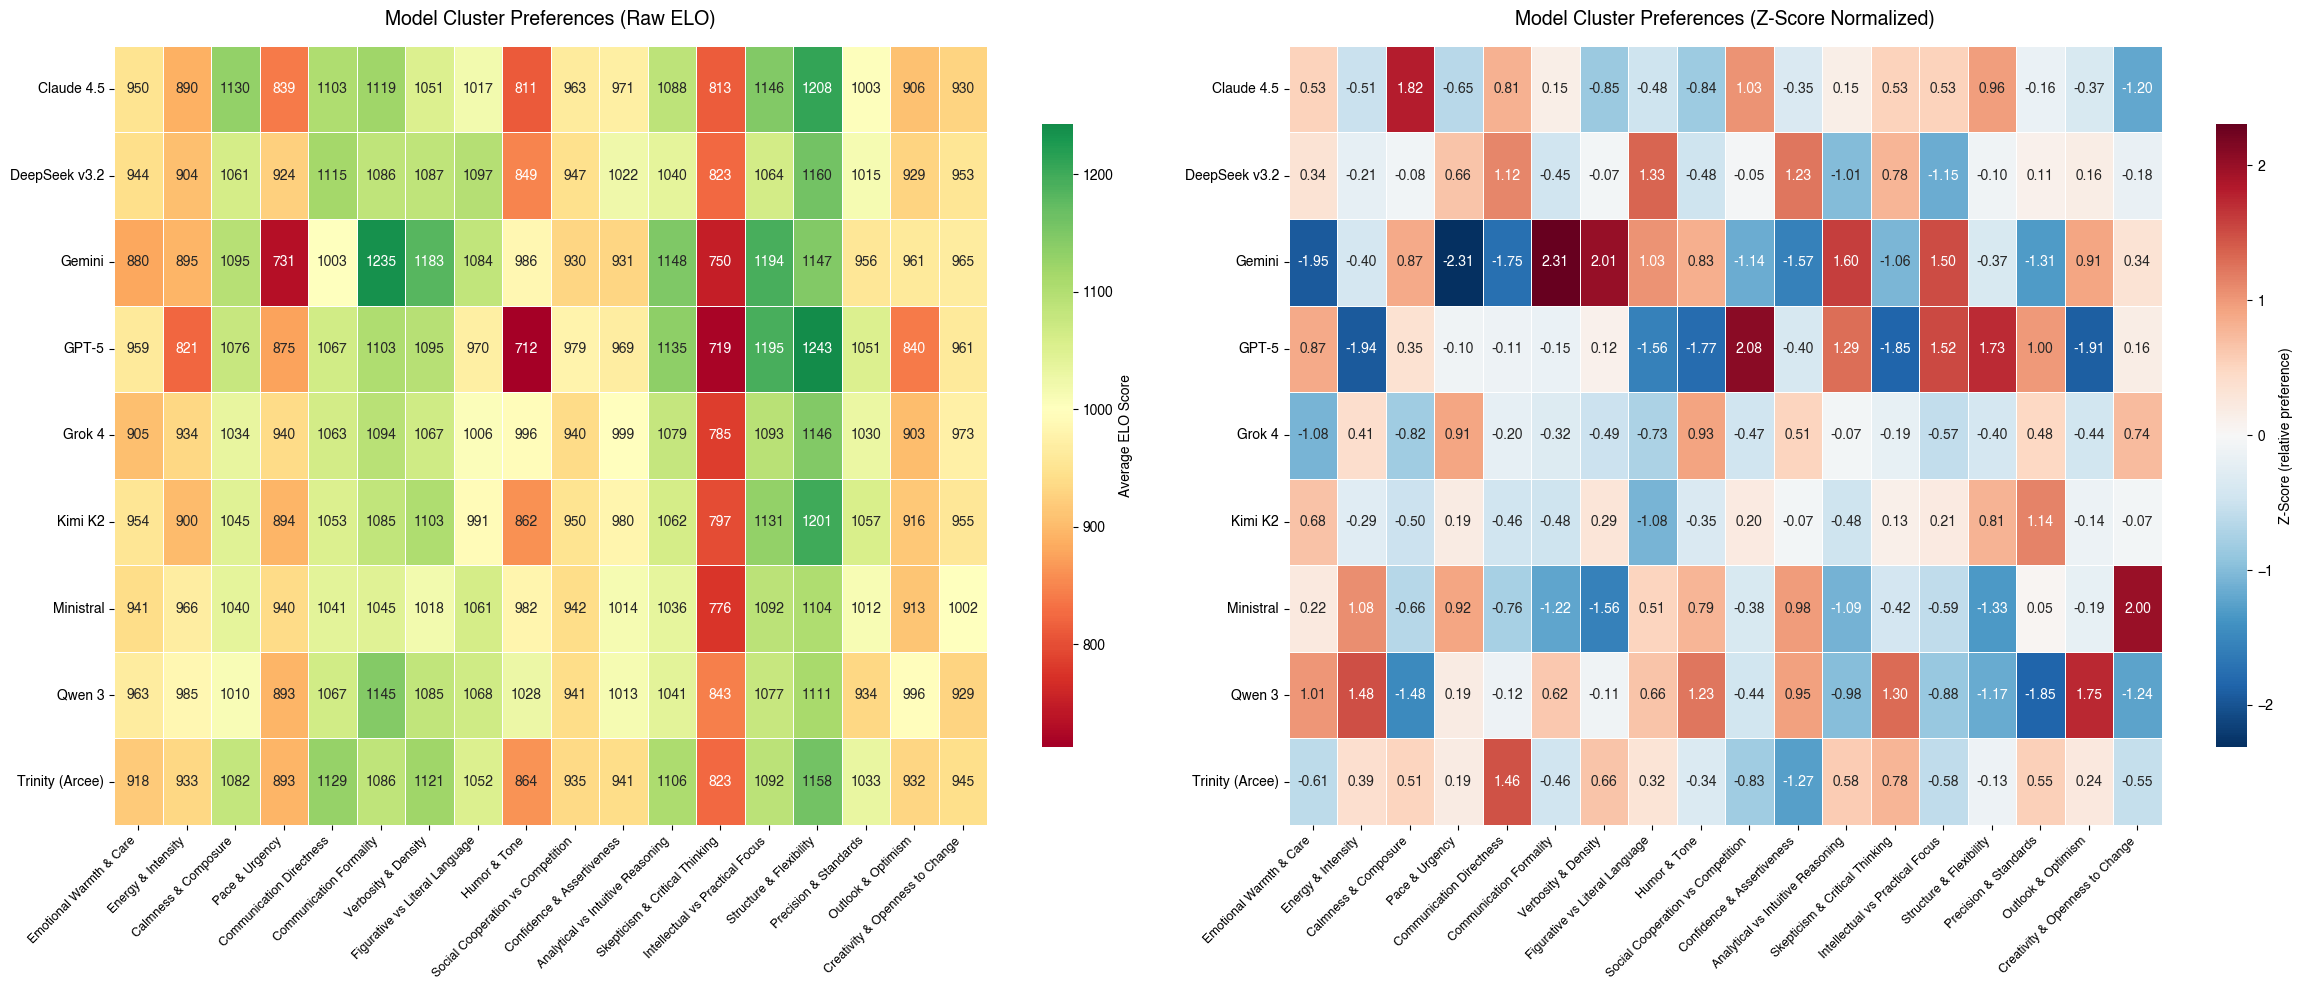


Interpretation:
  Left: Raw average ELO scores (green = higher preference, red = lower)
  Right: Z-scores show relative standing vs other models (blue = above avg, red = below avg)


In [27]:
# =============================================================================
# HEATMAP: Model Preferences Across Semantic Clusters
# =============================================================================

# Normalize cluster scores for visualization (z-score per cluster for comparability)
cluster_normalized = cluster_df.copy()
for col in cluster_normalized.columns:
    cluster_normalized[col] = (cluster_normalized[col] - cluster_normalized[col].mean()) / (cluster_normalized[col].std() + 1e-8)

fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Left: Raw ELO heatmap
ax1 = axes[0]
sns.heatmap(cluster_df, annot=True, fmt='.0f', cmap='RdYlGn', center=1000,
            linewidths=0.5, linecolor='white', ax=ax1, 
            cbar_kws={'label': 'Average ELO Score', 'shrink': 0.8})
ax1.set_title('Model Cluster Preferences (Raw ELO)', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=10)

# Right: Z-score normalized heatmap (comparative view)
ax2 = axes[1]
sns.heatmap(cluster_normalized, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            linewidths=0.5, linecolor='white', ax=ax2,
            cbar_kws={'label': 'Z-Score (relative preference)', 'shrink': 0.8})
ax2.set_title('Model Cluster Preferences (Z-Score Normalized)', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig('semantic_cluster_heatmap.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nInterpretation:")
print("  Left: Raw average ELO scores (green = higher preference, red = lower)")
print("  Right: Z-scores show relative standing vs other models (blue = above avg, red = below avg)")

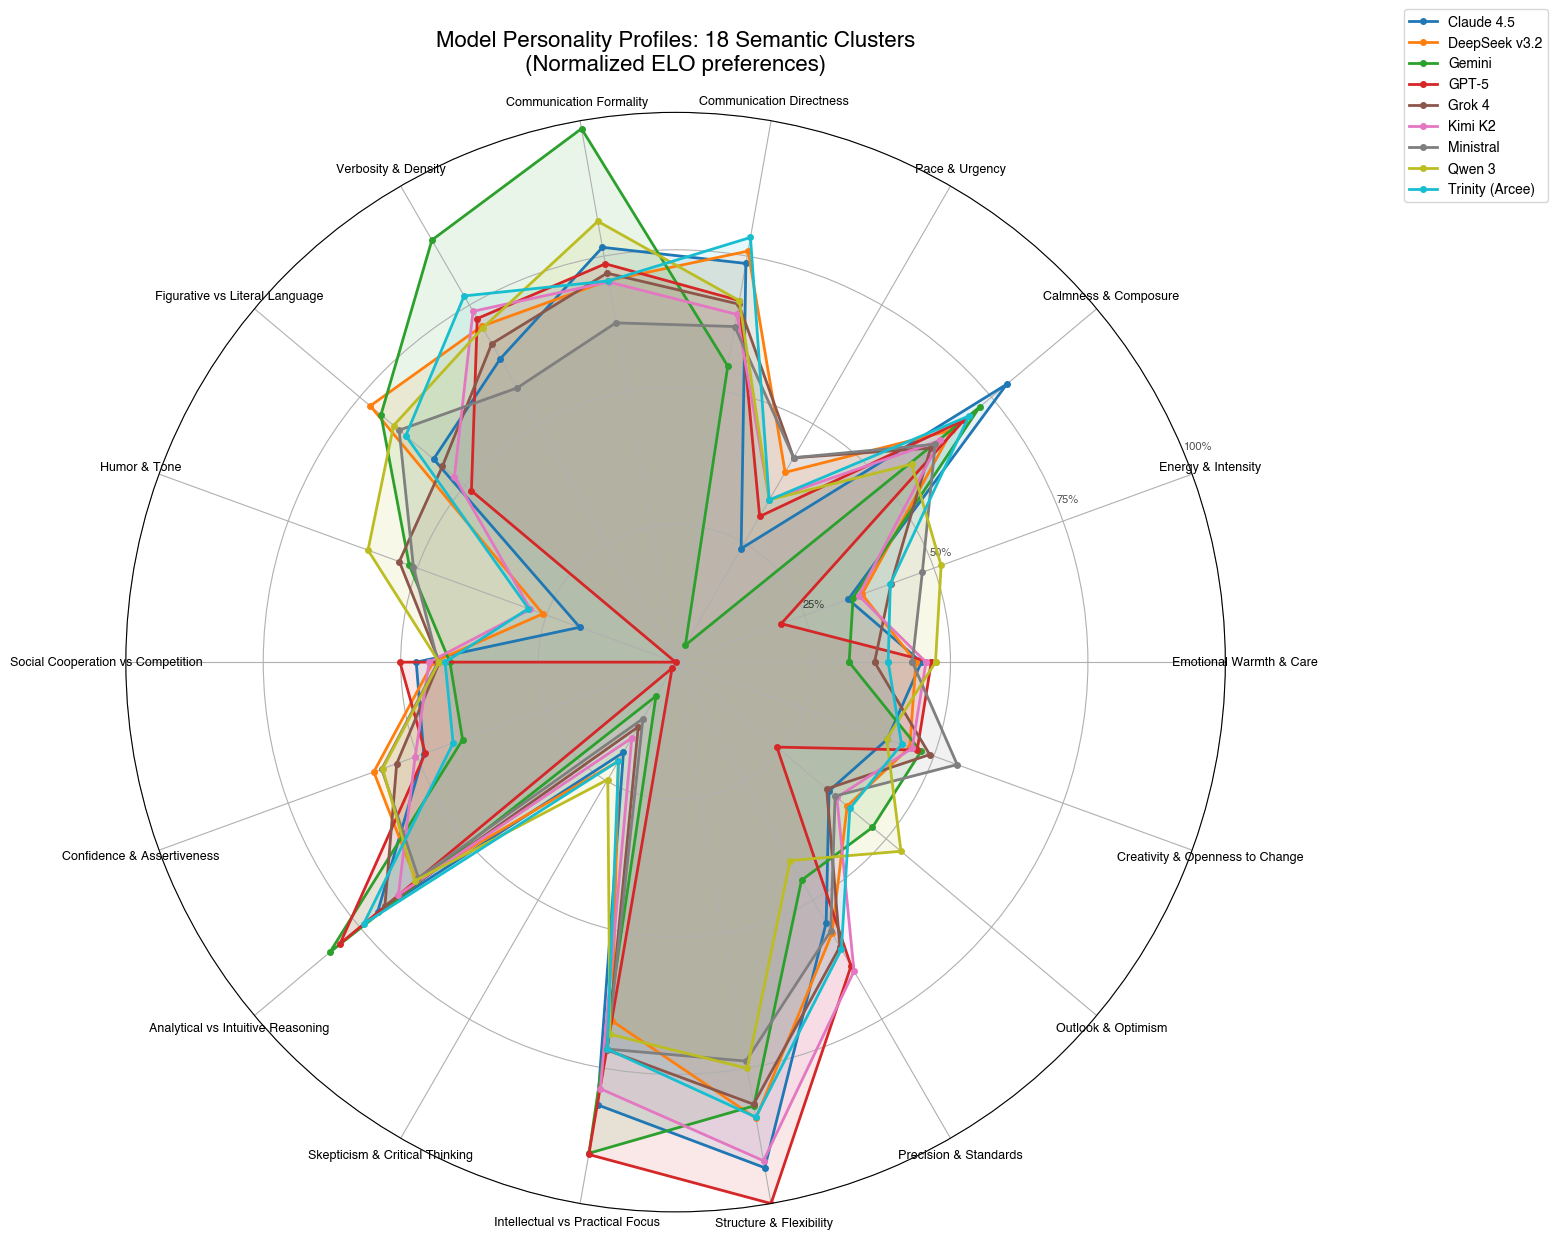

In [28]:
# =============================================================================
# RADAR CHART: Model Personality Profiles on Semantic Dimensions
# =============================================================================

from math import pi

# Normalize to 0-1 range for radar chart (using global min/max across all models/clusters)
all_cluster_values = cluster_df.values.flatten()
global_min, global_max = all_cluster_values.min(), all_cluster_values.max()
cluster_radar = (cluster_df - global_min) / (global_max - global_min)

# Prepare radar data
categories = cluster_names
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the circle

# Color palette for models
model_colors = plt.cm.tab10(np.linspace(0, 1, len(valid_models)))

fig, ax = plt.subplots(figsize=(16, 16), subplot_kw=dict(polar=True))

for idx, model in enumerate(cluster_radar.index):
    values = cluster_radar.loc[model].tolist()
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=model_colors[idx], markersize=4)
    ax.fill(angles, values, alpha=0.1, color=model_colors[idx])

# Configure radar chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=9, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['25%', '50%', '75%', '100%'], size=8, alpha=0.7)
ax.set_title('Model Personality Profiles: 18 Semantic Clusters\n(Normalized ELO preferences)', 
             size=16, fontweight='bold', pad=30)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

plt.tight_layout()
plt.savefig('semantic_cluster_radar.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

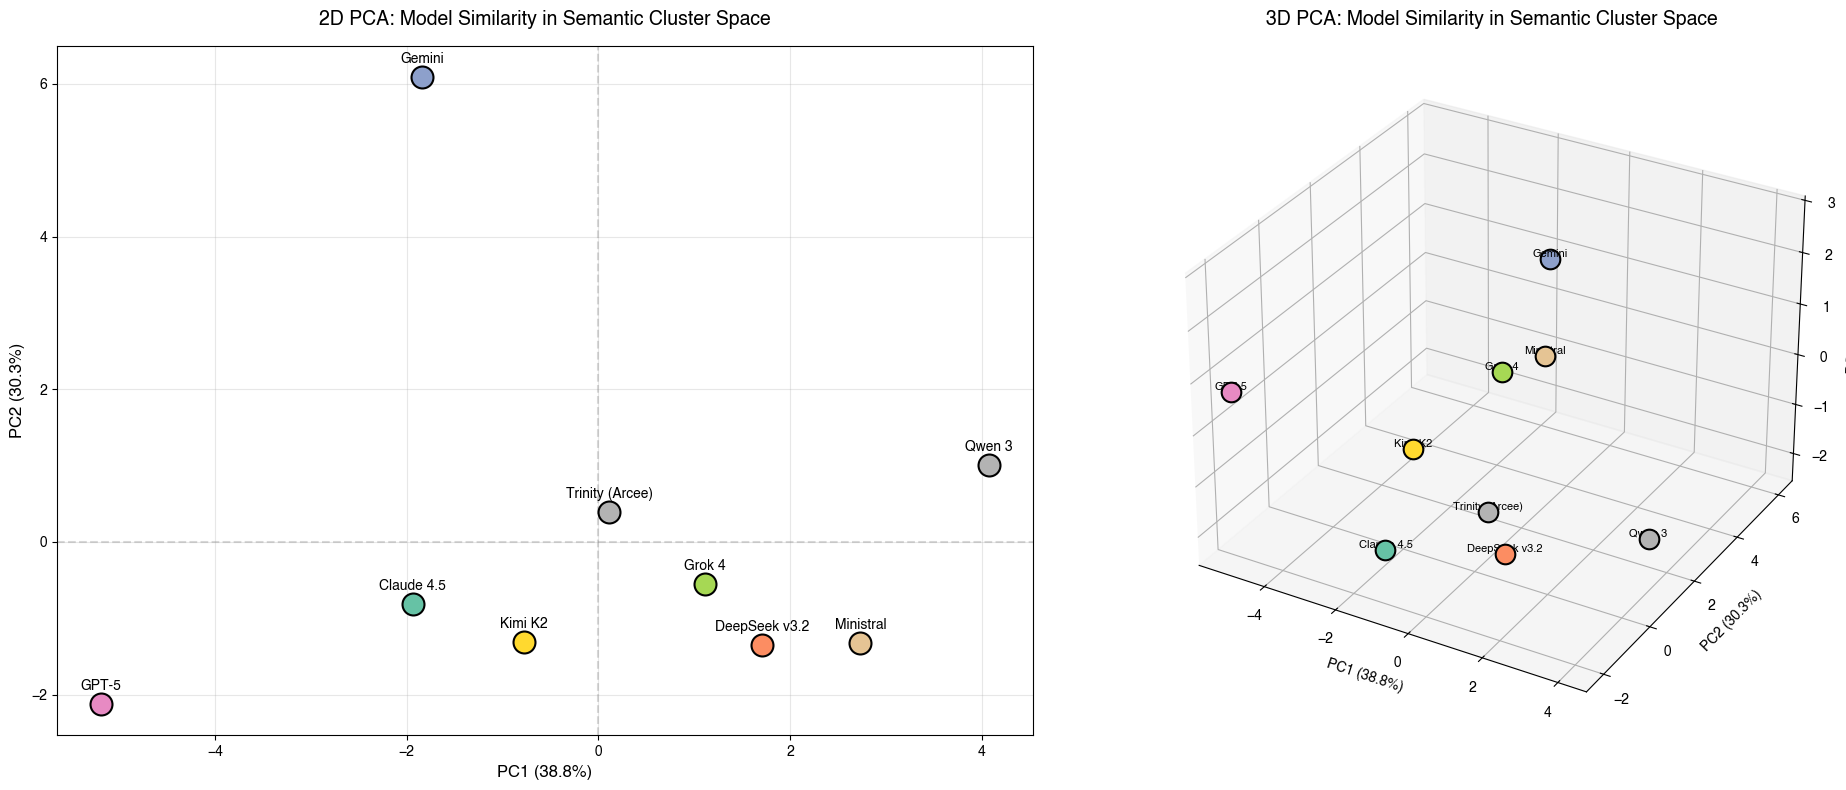


TOP CLUSTER LOADINGS PER PRINCIPAL COMPONENT

Total variance explained: 83.1%

PC1 (38.8% variance):
  + Energy & Intensity                       (loading: +0.357)
  - Structure & Flexibility                  (loading: -0.334)
  - Intellectual vs Practical Focus          (loading: -0.332)
  - Analytical vs Intuitive Reasoning        (loading: -0.308)
  + Humor & Tone                             (loading: +0.286)
  + Skepticism & Critical Thinking           (loading: +0.267)

PC2 (30.3% variance):
  + Communication Formality                  (loading: +0.384)
  - Pace & Urgency                           (loading: -0.345)
  + Verbosity & Density                      (loading: +0.322)
  - Emotional Warmth & Care                  (loading: -0.311)
  - Precision & Standards                    (loading: -0.295)
  - Social Cooperation vs Competition        (loading: -0.268)

PC3 (14.0% variance):
  + Creativity & Openness to Change          (loading: +0.591)
  - Communication Directness     

In [29]:
# =============================================================================
# PCA on SEMANTIC CLUSTERS: Model Similarity in Cluster Space
# =============================================================================
# This provides an interpretable alternative to trait-level PCA since each
# dimension corresponds to a semantically meaningful cluster.

# Standardize cluster data for PCA
from sklearn.preprocessing import StandardScaler

cluster_matrix = cluster_df.values
cluster_scaled = StandardScaler().fit_transform(cluster_matrix)

# 2D PCA on cluster space
pca_cluster_2d = PCA(n_components=2)
models_pca_2d = pca_cluster_2d.fit_transform(cluster_scaled)

# 3D PCA on cluster space
pca_cluster_3d = PCA(n_components=3)
models_pca_3d = pca_cluster_3d.fit_transform(cluster_scaled)

fig = plt.figure(figsize=(20, 8))

# --- 2D Plot ---
ax1 = fig.add_subplot(1, 2, 1)
colors = plt.cm.Set2(np.linspace(0, 1, len(cluster_df.index)))

for i, model in enumerate(cluster_df.index):
    ax1.scatter(models_pca_2d[i, 0], models_pca_2d[i, 1], s=250, c=[colors[i]], 
                edgecolors='black', linewidths=1.5, zorder=3)
    ax1.annotate(model, (models_pca_2d[i, 0], models_pca_2d[i, 1]), fontsize=10, 
                 fontweight='bold', ha='center', va='bottom', xytext=(0, 8), 
                 textcoords='offset points')

ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax1.set_xlabel(f'PC1 ({pca_cluster_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12, fontweight='bold')
ax1.set_ylabel(f'PC2 ({pca_cluster_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12, fontweight='bold')
ax1.set_title('2D PCA: Model Similarity in Semantic Cluster Space', fontsize=14, fontweight='bold', pad=15)
ax1.grid(alpha=0.3)

# --- 3D Plot ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

for i, model in enumerate(cluster_df.index):
    ax2.scatter(models_pca_3d[i, 0], models_pca_3d[i, 1], models_pca_3d[i, 2], 
                s=200, c=[colors[i]], edgecolors='black', linewidths=1.5, zorder=3)
    ax2.text(models_pca_3d[i, 0], models_pca_3d[i, 1], models_pca_3d[i, 2], 
             model, fontsize=8, fontweight='bold', ha='center', va='bottom')

ax2.set_xlabel(f'PC1 ({pca_cluster_3d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10, fontweight='bold')
ax2.set_ylabel(f'PC2 ({pca_cluster_3d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10, fontweight='bold')
ax2.set_zlabel(f'PC3 ({pca_cluster_3d.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10, fontweight='bold')
ax2.set_title('3D PCA: Model Similarity in Semantic Cluster Space', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('semantic_cluster_pca.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Print cluster loadings for each PC
print("\n" + "="*80)
print("TOP CLUSTER LOADINGS PER PRINCIPAL COMPONENT")
print("="*80)
print(f"\nTotal variance explained: {sum(pca_cluster_3d.explained_variance_ratio_)*100:.1f}%\n")

for pc_idx in range(3):
    loadings = pca_cluster_3d.components_[pc_idx]
    sorted_idx = np.argsort(np.abs(loadings))[::-1]
    
    print(f"PC{pc_idx+1} ({pca_cluster_3d.explained_variance_ratio_[pc_idx]*100:.1f}% variance):")
    for j in range(min(6, len(cluster_names))):
        cluster = cluster_names[sorted_idx[j]]
        val = loadings[sorted_idx[j]]
        direction = "+" if val > 0 else "-"
        print(f"  {direction} {cluster:40s} (loading: {val:+.3f})")
    print()

MODEL PERSONALITY PROFILES: Top 3 and Bottom 3 Cluster Preferences

Claude 4.5:
  STRONGEST preferences:
    • Structure & Flexibility: 1208
    • Intellectual vs Practical Focus: 1146
    • Calmness & Composure: 1130
  WEAKEST preferences:
    • Pace & Urgency: 839
    • Skepticism & Critical Thinking: 813
    • Humor & Tone: 811

DeepSeek v3.2:
  STRONGEST preferences:
    • Structure & Flexibility: 1160
    • Communication Directness: 1115
    • Figurative vs Literal Language: 1097
  WEAKEST preferences:
    • Energy & Intensity: 904
    • Humor & Tone: 849
    • Skepticism & Critical Thinking: 823

Gemini:
  STRONGEST preferences:
    • Communication Formality: 1235
    • Intellectual vs Practical Focus: 1194
    • Verbosity & Density: 1183
  WEAKEST preferences:
    • Emotional Warmth & Care: 880
    • Skepticism & Critical Thinking: 750
    • Pace & Urgency: 731

GPT-5:
  STRONGEST preferences:
    • Structure & Flexibility: 1243
    • Intellectual vs Practical Focus: 1195
    • 

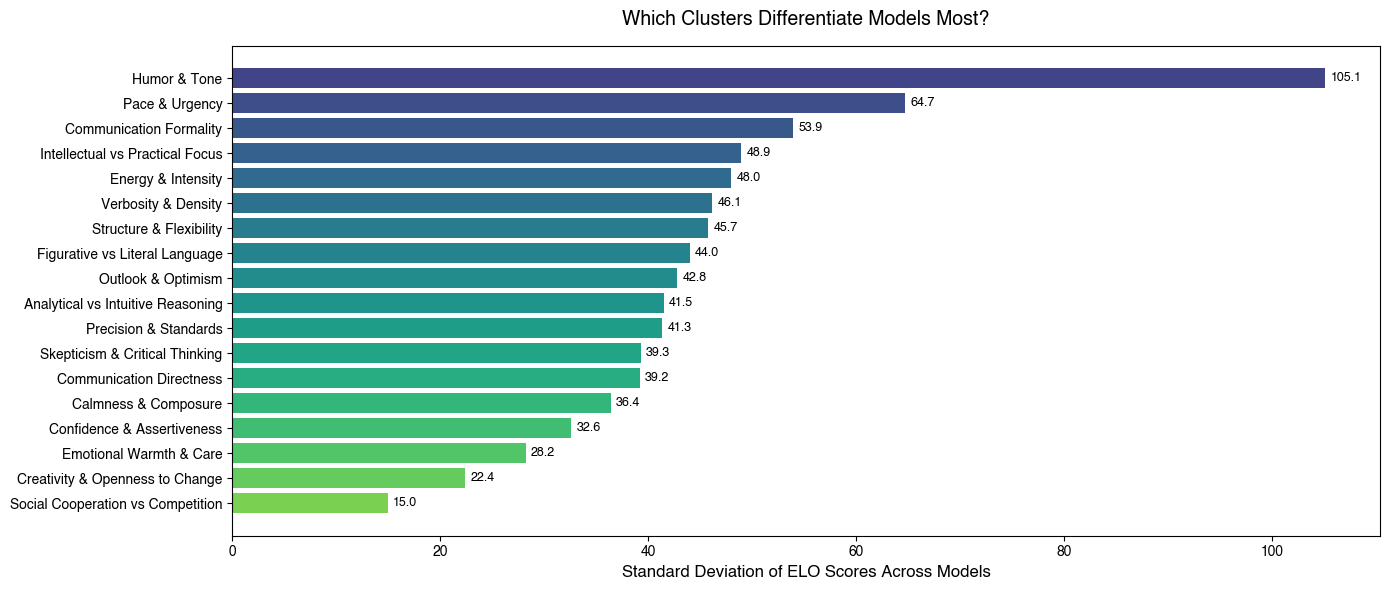

In [30]:
# =============================================================================
# CLUSTER ANALYSIS: Model Distinctiveness & Cluster Rankings
# =============================================================================

# For each model, rank their preference for each cluster (1 = most preferred)
cluster_ranks = cluster_df.rank(axis=1, ascending=False).astype(int)

# Find distinctive preferences per model
print("="*80)
print("MODEL PERSONALITY PROFILES: Top 3 and Bottom 3 Cluster Preferences")
print("="*80)

for model in cluster_df.index:
    model_row = cluster_df.loc[model]
    sorted_clusters = model_row.sort_values(ascending=False)
    
    top_3 = sorted_clusters.head(3)
    bottom_3 = sorted_clusters.tail(3)
    
    print(f"\n{model}:")
    print(f"  STRONGEST preferences:")
    for cluster, elo in top_3.items():
        print(f"    • {cluster}: {elo:.0f}")
    print(f"  WEAKEST preferences:")
    for cluster, elo in bottom_3.items():
        print(f"    • {cluster}: {elo:.0f}")

# Create a summary visualization: which clusters differentiate models most?
print("\n" + "="*80)
print("CLUSTER VARIANCE ACROSS MODELS (Most Differentiating Clusters)")
print("="*80)

cluster_variance = cluster_df.std(axis=0).sort_values(ascending=False)
print("\nClusters ranked by cross-model variance (higher = more differentiating):\n")
for i, (cluster, var) in enumerate(cluster_variance.items(), 1):
    print(f"  {i:2d}. {cluster:40s} (σ = {var:.1f})")

# Bar chart of cluster variance
fig, ax = plt.subplots(figsize=(14, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(cluster_variance)))
bars = ax.barh(range(len(cluster_variance)), cluster_variance.values, color=colors)
ax.set_yticks(range(len(cluster_variance)))
ax.set_yticklabels(cluster_variance.index, fontsize=10)
ax.set_xlabel('Standard Deviation of ELO Scores Across Models', fontsize=12, fontweight='bold')
ax.set_title('Which Clusters Differentiate Models Most?', fontsize=14, fontweight='bold', pad=15)
ax.invert_yaxis()

# Add value labels
for bar, val in zip(bars, cluster_variance.values):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}', 
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig('cluster_differentiation.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

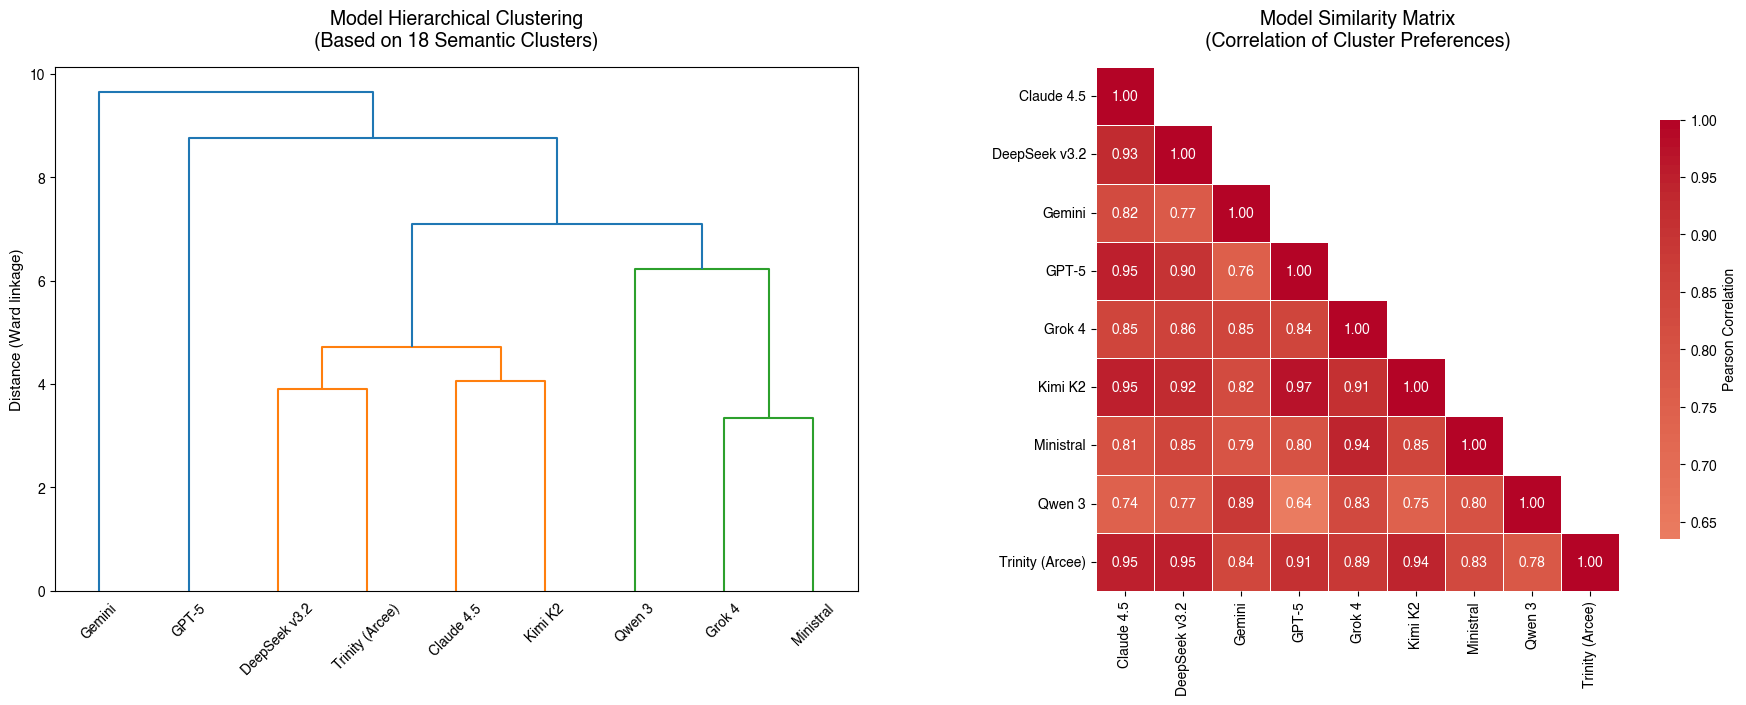


MODEL SIMILARITY RANKINGS (Based on Semantic Cluster Preferences)

Most similar model pairs:
  GPT-5 ↔ Kimi K2: r = 0.970
  Claude 4.5 ↔ GPT-5: r = 0.952
  Claude 4.5 ↔ Kimi K2: r = 0.951
  DeepSeek v3.2 ↔ Trinity (Arcee): r = 0.947
  Claude 4.5 ↔ Trinity (Arcee): r = 0.946

Least similar model pairs:
  DeepSeek v3.2 ↔ Gemini: r = 0.767
  Gemini ↔ GPT-5: r = 0.756
  Kimi K2 ↔ Qwen 3: r = 0.745
  Claude 4.5 ↔ Qwen 3: r = 0.745
  GPT-5 ↔ Qwen 3: r = 0.635


In [31]:
# =============================================================================
# HIERARCHICAL CLUSTERING: Model Similarity Based on Semantic Clusters
# =============================================================================
# Compare model groupings based on semantic cluster preferences vs raw trait PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Compute linkage matrix using standardized cluster data
linkage_matrix = linkage(cluster_scaled, method='ward')

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Dendrogram ---
ax1 = axes[0]
dend = dendrogram(linkage_matrix, labels=list(cluster_df.index), ax=ax1, 
                  leaf_rotation=45, leaf_font_size=10)
ax1.set_title('Model Hierarchical Clustering\n(Based on 18 Semantic Clusters)', 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Distance (Ward linkage)', fontsize=11)

# --- Correlation heatmap between models ---
ax2 = axes[1]
model_corr = cluster_df.T.corr()
mask = np.triu(np.ones_like(model_corr, dtype=bool), k=1)
sns.heatmap(model_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            mask=mask, square=True, ax=ax2, linewidths=0.5,
            cbar_kws={'label': 'Pearson Correlation', 'shrink': 0.8})
ax2.set_title('Model Similarity Matrix\n(Correlation of Cluster Preferences)', 
              fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('model_clustering_semantic.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Print most/least similar model pairs
print("\n" + "="*80)
print("MODEL SIMILARITY RANKINGS (Based on Semantic Cluster Preferences)")
print("="*80)

# Get all pairwise correlations
pairs = []
for i, m1 in enumerate(model_corr.index):
    for j, m2 in enumerate(model_corr.columns):
        if i < j:
            pairs.append((m1, m2, model_corr.loc[m1, m2]))

pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

print("\nMost similar model pairs:")
for m1, m2, corr in pairs_sorted[:5]:
    print(f"  {m1} ↔ {m2}: r = {corr:.3f}")

print("\nLeast similar model pairs:")
for m1, m2, corr in pairs_sorted[-5:]:
    print(f"  {m1} ↔ {m2}: r = {corr:.3f}")

COMPARISON: SEMANTIC CLUSTERS vs DATA-DRIVEN PCA

1. DIMENSIONALITY REDUCTION COMPARISON
--------------------------------------------------
   Original trait space: 144 dimensions
   Semantic clusters: 18 dimensions
   PCA on clusters (3 components): 83.1% variance

2. CLUSTER SIZE DISTRIBUTION
--------------------------------------------------
   Min traits per cluster: 4
   Max traits per cluster: 15
   Mean traits per cluster: 8.0
   Median traits per cluster: 8.0

3. SEMANTIC CLUSTER SUMMARY TABLE
--------------------------------------------------


Cluster  N Traits      Avg ELO  Model Variance  \
8                        Humor & Tone         5   898.902444      105.088959   
3                      Pace & Urgency         8   881.123194       64.709083   
5             Communication Formality         5  1110.919778       53.922400   
13    Intellectual vs Practical Focus        11  1120.401313       48.942308   
1                  Energy & Intensity         8   914.234028       47.982271   
6                 Verbosity & Density         4  1090.040556       46.140721   
14            Structure & Flexibility         9  1164.187778       45.740882   
7      Figurative vs Literal Language         6  1038.512407       44.001628   
16                 Outlook & Optimism         5   921.757778       42.773709   
11  Analytical vs Intuitive Reasoning        11  1081.639596       41.486685   
15              Precision & Standards         8  1009.919583       41.324994   
12     Skepticism & Critical Thinking         6   792.118519       39.297892   
4            Communication Directness         5  1071.294667       39.195735   
2                Calmness & Composure         8  1063.653056       36.395003   
10         Confidence & Assertiveness        10   982.462889       32.584004   
0             Emotional Warmth & Care        11   934.922626       28.200268   
17    Creativity & Openness to Change        15   956.984148       22.390928   
9   Social Cooperation vs Competition         9   947.396543       14.964071   

                                  Sample Traits  
8             serious, irreverent, sarcastic...  
3           impulsive, spontaneous, cautious...  
5               casual, colloquial, academic...  
13  specialized, intellectual, philosophical...  
1          excitable, enthusiastic, reserved...  
6             minimalist, elaborate, verbose...  
14          focused, structured, disciplined...  
7              poetic, prosaic, metaphorical...  
16         idealistic, optimistic, realistic...  
11              rational, logical, objective...  
15   perfectionist, approximate, satisficing...  
12         contrarian, critical, challenging...  
4                    blunt, indirect, direct...  
2                reflective, balanced, stoic...  
10              deferential, bold, confident...  
0              remorseful, warm, encouraging...  
17       traditional, progressive, nostalgic...  
9         diplomatic, agreeable, cooperative...

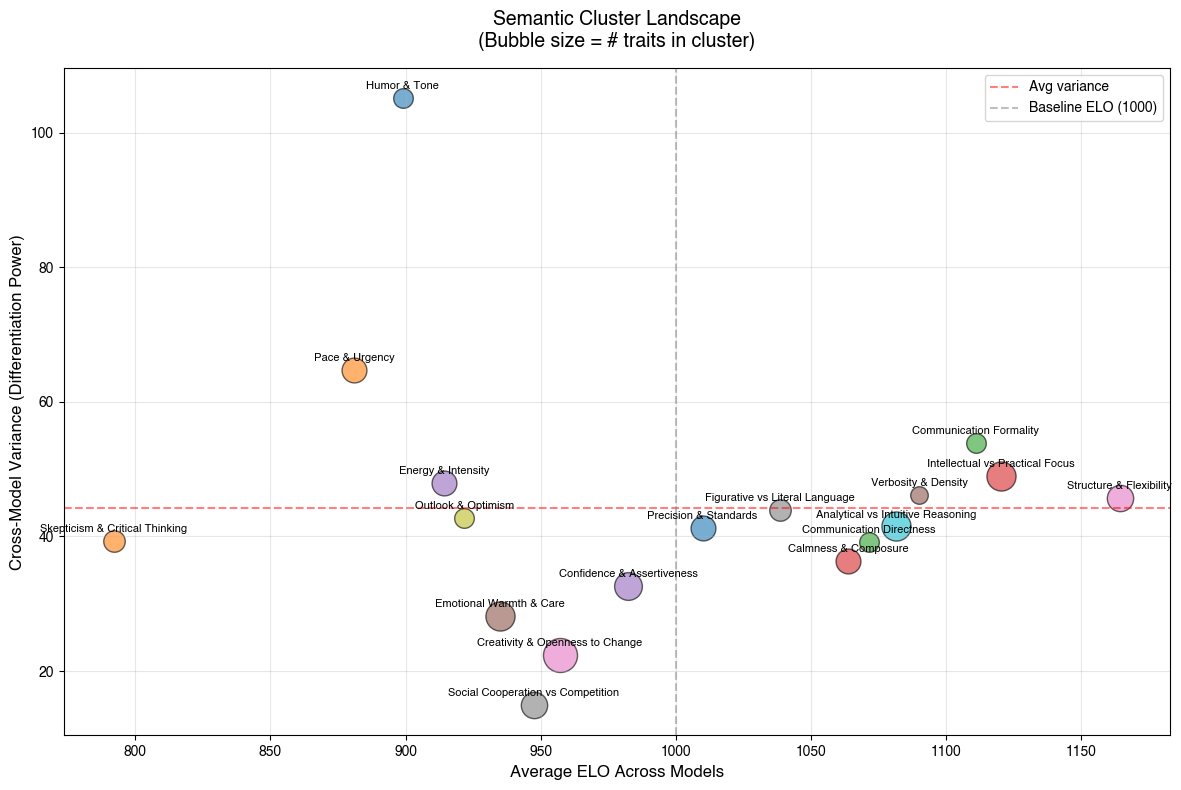


Interpretation:
  • Clusters above the red line differentiate models more strongly
  • Clusters right of the vertical line are generally preferred by all models
  • Larger bubbles contain more traits, giving more granular signal


In [32]:
# =============================================================================
# COMPARATIVE SUMMARY: Semantic Clusters vs Data-Driven PCA
# =============================================================================

print("="*80)
print("COMPARISON: SEMANTIC CLUSTERS vs DATA-DRIVEN PCA")
print("="*80)

# Compute variance explained at different granularities
print("\n1. DIMENSIONALITY REDUCTION COMPARISON")
print("-" * 50)
print(f"   Original trait space: 144 dimensions")
print(f"   Semantic clusters: 18 dimensions")
print(f"   PCA on clusters (3 components): {sum(pca_cluster_3d.explained_variance_ratio_)*100:.1f}% variance")

# Show cluster sizes distribution
cluster_sizes = [len(cluster_to_traits[c]) for c in cluster_names]
print(f"\n2. CLUSTER SIZE DISTRIBUTION")
print("-" * 50)
print(f"   Min traits per cluster: {min(cluster_sizes)}")
print(f"   Max traits per cluster: {max(cluster_sizes)}")
print(f"   Mean traits per cluster: {np.mean(cluster_sizes):.1f}")
print(f"   Median traits per cluster: {np.median(cluster_sizes):.1f}")

# Create a summary table
print(f"\n3. SEMANTIC CLUSTER SUMMARY TABLE")
print("-" * 50)
summary_data = []
for cluster in cluster_names:
    traits = cluster_to_traits[cluster]
    avg_elo_all_models = np.mean([cluster_df[cluster].mean()])
    var_across_models = cluster_df[cluster].std()
    summary_data.append({
        'Cluster': cluster,
        'N Traits': len(traits),
        'Avg ELO': avg_elo_all_models,
        'Model Variance': var_across_models,
        'Sample Traits': ', '.join(traits[:3]) + ('...' if len(traits) > 3 else '')
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Model Variance', ascending=False)
display(summary_df)

# Final interpretive plot: cluster importance weighted by differentiation power
fig, ax = plt.subplots(figsize=(12, 8))

# Create bubble chart: x = avg ELO, y = model variance, size = # traits
for idx, row in summary_df.iterrows():
    ax.scatter(row['Avg ELO'], row['Model Variance'], 
               s=row['N Traits']*40, alpha=0.6, edgecolors='black', linewidths=1)
    ax.annotate(row['Cluster'], (row['Avg ELO'], row['Model Variance']),
                fontsize=8, ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

ax.axhline(y=summary_df['Model Variance'].mean(), color='red', linestyle='--', alpha=0.5, label='Avg variance')
ax.axvline(x=1000, color='gray', linestyle='--', alpha=0.5, label='Baseline ELO (1000)')

ax.set_xlabel('Average ELO Across Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Cross-Model Variance (Differentiation Power)', fontsize=12, fontweight='bold')
ax.set_title('Semantic Cluster Landscape\n(Bubble size = # traits in cluster)', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('cluster_landscape.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nInterpretation:")
print("  • Clusters above the red line differentiate models more strongly")
print("  • Clusters right of the vertical line are generally preferred by all models")
print("  • Larger bubbles contain more traits, giving more granular signal")

In [33]:
# =============================================================================
# MODEL WEIRDNESS INDEX: Quantifying How Unusual Each Model's Preferences Are
# =============================================================================
# Multiple metrics to capture different aspects of "weirdness" in model preferences

from scipy.spatial.distance import cdist, euclidean
from scipy.stats import zscore

# Use standardized cluster data for fair comparison
cluster_matrix = cluster_df.values
cluster_scaled = StandardScaler().fit_transform(cluster_matrix)
model_names_display = list(cluster_df.index)

# Calculate centroid (average model profile)
centroid = cluster_scaled.mean(axis=0)

weirdness_metrics = {}

for i, model in enumerate(model_names_display):
    profile = cluster_scaled[i]
    
    # 1. EUCLIDEAN DISTANCE FROM CENTROID
    # How far is this model from the "average" model?
    dist_from_centroid = euclidean(profile, centroid)
    
    # 2. AVERAGE ABSOLUTE Z-SCORE
    # How extreme are this model's preferences on average?
    avg_abs_zscore = np.mean(np.abs(profile))
    
    # 3. OUTLIER CLUSTER COUNT
    # In how many clusters is this model >1.5 std from mean?
    outlier_count = np.sum(np.abs(profile) > 1.5)
    extreme_outlier_count = np.sum(np.abs(profile) > 2.0)
    
    # 4. ISOLATION SCORE (avg distance to all other models)
    # Lonely models that don't cluster with others
    distances_to_others = [euclidean(profile, cluster_scaled[j]) 
                           for j in range(len(model_names_display)) if j != i]
    isolation_score = np.mean(distances_to_others)
    
    # 5. PROFILE SPIKINESS (standard deviation of z-scores)
    # High = very polarized preferences; Low = flat/uniform
    spikiness = np.std(profile)
    
    # 6. MAX DEVIATION
    # Single most extreme preference
    max_deviation = np.max(np.abs(profile))
    max_dev_cluster = cluster_names[np.argmax(np.abs(profile))]
    max_dev_direction = "high" if profile[np.argmax(np.abs(profile))] > 0 else "low"
    
    weirdness_metrics[model] = {
        'dist_from_centroid': dist_from_centroid,
        'avg_abs_zscore': avg_abs_zscore,
        'outlier_clusters': outlier_count,
        'extreme_outliers': extreme_outlier_count,
        'isolation_score': isolation_score,
        'spikiness': spikiness,
        'max_deviation': max_deviation,
        'max_dev_cluster': max_dev_cluster,
        'max_dev_direction': max_dev_direction
    }

# Create DataFrame
weirdness_df = pd.DataFrame(weirdness_metrics).T

# COMPOSITE WEIRDNESS INDEX (normalized sum of key metrics)
# Normalize each metric to 0-1 range, then average
metrics_to_combine = ['dist_from_centroid', 'avg_abs_zscore', 'isolation_score', 'spikiness']
weirdness_normalized = weirdness_df[metrics_to_combine].copy()
for col in metrics_to_combine:
    min_val, max_val = weirdness_normalized[col].min(), weirdness_normalized[col].max()
    weirdness_normalized[col] = (weirdness_normalized[col] - min_val) / (max_val - min_val + 1e-8)

weirdness_df['WEIRDNESS_INDEX'] = weirdness_normalized.mean(axis=1)
weirdness_df = weirdness_df.sort_values('WEIRDNESS_INDEX', ascending=False)

print("="*80)
print("MODEL WEIRDNESS INDEX: How Unusual Are Each Model's Preferences?")
print("="*80)
print("\nMetrics explained:")
print("  • dist_from_centroid: Distance from average model profile")
print("  • avg_abs_zscore: Average extremity of preferences")
print("  • outlier_clusters: # clusters where model is >1.5σ from mean")
print("  • isolation_score: Average distance to other models (loneliness)")
print("  • spikiness: How polarized the preference profile is")
print("  • WEIRDNESS_INDEX: Composite score (0-1, higher = weirder)")
print()

display(weirdness_df[['WEIRDNESS_INDEX', 'dist_from_centroid', 'isolation_score', 
                       'outlier_clusters', 'spikiness', 'max_dev_cluster', 'max_dev_direction']].round(3))

MODEL WEIRDNESS INDEX: How Unusual Are Each Model's Preferences?

Metrics explained:
  • dist_from_centroid: Distance from average model profile
  • avg_abs_zscore: Average extremity of preferences
  • outlier_clusters: # clusters where model is >1.5σ from mean
  • isolation_score: Average distance to other models (loneliness)
  • spikiness: How polarized the preference profile is
  • WEIRDNESS_INDEX: Composite score (0-1, higher = weirder)



WEIRDNESS_INDEX dist_from_centroid isolation_score  \
Gemini                      1.0           6.431501        8.144973   
GPT-5                  0.797226           5.798081        7.441395   
Qwen 3                 0.611045           4.941642        6.713481   
Ministral              0.444334           4.304271        6.157457   
Claude 4.5             0.265616           3.503587        5.697283   
Trinity (Arcee)        0.157011            3.01883        5.373713   
DeepSeek v3.2          0.149428           3.116482        5.335112   
Grok 4                 0.088524           2.719521        5.137048   
Kimi K2                     0.0           2.361093        4.984274   

                outlier_clusters spikiness                    max_dev_cluster  \
Gemini                         8  1.515664                     Pace & Urgency   
GPT-5                          8  1.366029  Social Cooperation vs Competition   
Qwen 3                         4  1.163434              Precision & Standards   
Ministral                      2   1.00975    Creativity & Openness to Change   
Claude 4.5                     1  0.823257               Calmness & Composure   
Trinity (Arcee)                1  0.709546           Communication Directness   
DeepSeek v3.2                  0  0.725377     Figurative vs Literal Language   
Grok 4                         0  0.632069            Emotional Warmth & Care   
Kimi K2                        0  0.556273              Precision & Standards   

                max_dev_direction  
Gemini                        low  
GPT-5                        high  
Qwen 3                        low  
Ministral                    high  
Claude 4.5                   high  
Trinity (Arcee)              high  
DeepSeek v3.2                high  
Grok 4                        low  
Kimi K2                      high

/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/3358428611.py:48: UserWarning: Glyph 8593 (\N{UPWARDS ARROW}) missing from font(s) Helvetica.
  plt.tight_layout()
/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/3358428611.py:48: UserWarning: Glyph 8595 (\N{DOWNWARDS ARROW}) missing from font(s) Helvetica.
  plt.tight_layout()
/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/3358428611.py:49: UserWarning: Glyph 8593 (\N{UPWARDS ARROW}) missing from font(s) Helvetica.
  plt.savefig('model_weirdness_spectrum.png', dpi=200, bbox_inches='tight', facecolor='white')
/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/3358428611.py:49: UserWarning: Glyph 8595 (\N{DOWNWARDS ARROW}) missing from font(s) Helvetica.
  plt.savefig('model_weirdness_spectrum.png', dpi=200, bbox_inches='tight', facecolor='white')
/Users/student/Desktop/ai+design/character_elicitation/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWa

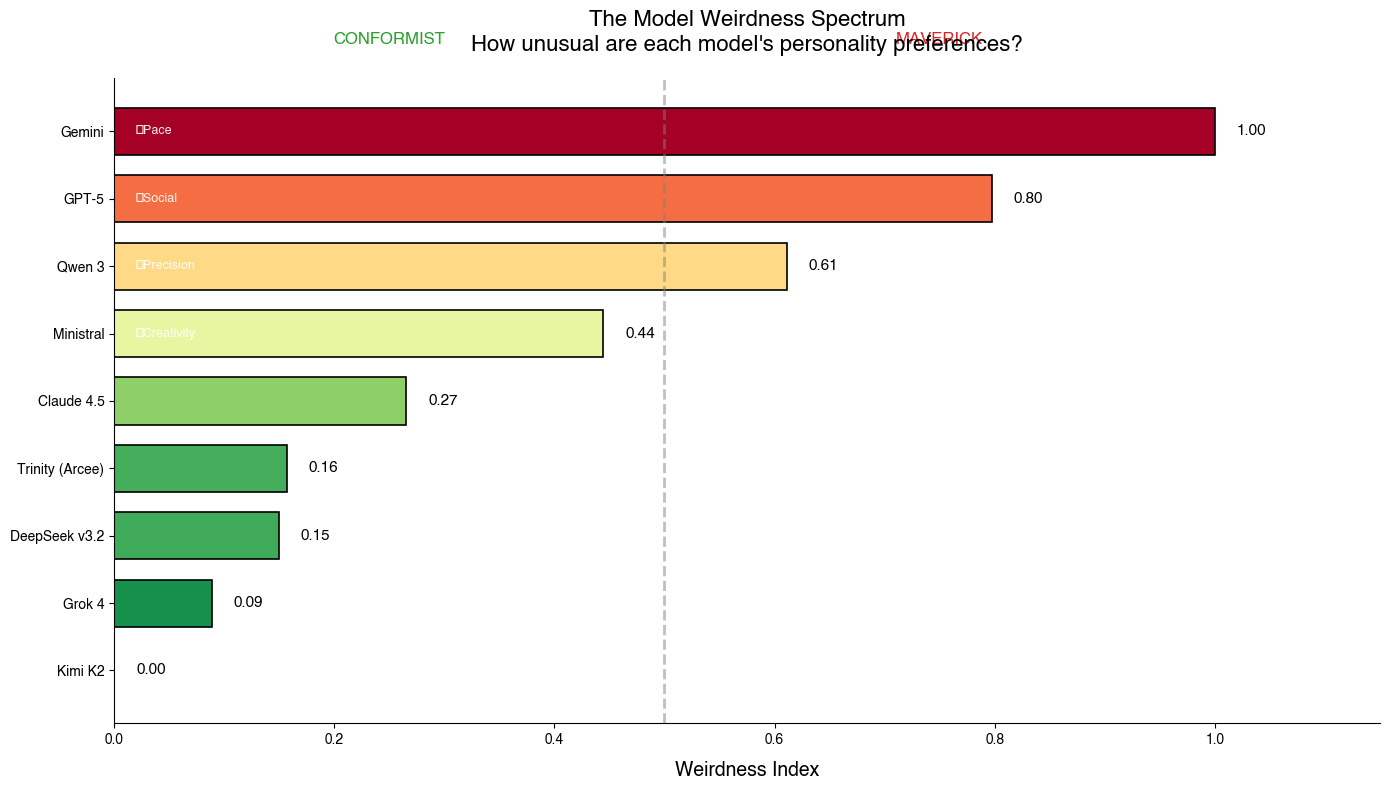


📊 Hero visualization saved as 'model_weirdness_spectrum.png'

Key takeaways for your story:
  1. Gemini is the most distinctive model (weirdness: 1.00)
  2. Kimi K2 most closely matches the 'average' model profile
  3. The weirdness spectrum ranges from 0.00 to 1.00


In [37]:
# =============================================================================
# HERO VISUALIZATION: The Weirdness Spectrum (for presentations/papers)
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

# Sort by weirdness for clean visual
plot_df = weirdness_df.sort_values('WEIRDNESS_INDEX', ascending=True).reset_index()
plot_df.columns = ['Model'] + list(plot_df.columns[1:])

# Create gradient colormap based on weirdness
cmap = plt.cm.RdYlGn_r
norm = plt.Normalize(plot_df['WEIRDNESS_INDEX'].min(), plot_df['WEIRDNESS_INDEX'].max())

# Main horizontal bar chart
bars = ax.barh(plot_df['Model'], plot_df['WEIRDNESS_INDEX'], 
               color=[cmap(norm(v)) for v in plot_df['WEIRDNESS_INDEX']],
               edgecolor='black', linewidth=1.2, height=0.7)

# Add distinctive feature annotations
for i, (_, row) in enumerate(plot_df.iterrows()):
    model = row['Model']
    weird_idx = row['WEIRDNESS_INDEX']
    max_cluster = row['max_dev_cluster'].split()[0]  # First word only
    direction = "↑" if row['max_dev_direction'] == 'high' else "↓"
    
    # Value label
    ax.text(weird_idx + 0.02, i, f'{weird_idx:.2f}', va='center', fontsize=11, fontweight='bold')
    
    # What makes them weird (annotation)
    if weird_idx > 0.3:
        ax.text(0.02, i, f'{direction}{max_cluster}', va='center', fontsize=9, 
                color='white', fontweight='bold', alpha=0.9)

# Style
ax.set_xlim(0, 1.15)
ax.set_xlabel('Weirdness Index', fontsize=14, fontweight='bold', labelpad=10)
ax.set_title('The Model Weirdness Spectrum\nHow unusual are each model\'s personality preferences?', 
             fontsize=16, fontweight='bold', pad=20)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=2)
ax.text(0.25, len(plot_df) + 0.3, 'CONFORMIST', ha='center', fontsize=12, fontweight='bold', color='#2ca02c')
ax.text(0.75, len(plot_df) + 0.3, 'MAVERICK', ha='center', fontsize=12, fontweight='bold', color='#d62728')

# Remove spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('model_weirdness_spectrum.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print("\n📊 Hero visualization saved as 'model_weirdness_spectrum.png'")
print("\nKey takeaways for your story:")
print(f"  1. {plot_df.iloc[-1]['Model']} is the most distinctive model (weirdness: {plot_df.iloc[-1]['WEIRDNESS_INDEX']:.2f})")
print(f"  2. {plot_df.iloc[0]['Model']} most closely matches the 'average' model profile")
print(f"  3. The weirdness spectrum ranges from {plot_df['WEIRDNESS_INDEX'].min():.2f} to {plot_df['WEIRDNESS_INDEX'].max():.2f}")

In [35]:
# =============================================================================
# THE STORY: Narrative Summary of Model Weirdness
# =============================================================================

print("="*80)
print("THE WEIRDNESS NARRATIVE: What Makes Each Model Distinctive?")
print("="*80)

# Generate narrative for each model
for model in weirdness_df.index:
    metrics = weirdness_df.loc[model]
    model_idx = model_names_display.index(model)
    profile = cluster_scaled[model_idx]
    
    # Find top 2 positive and negative deviations
    sorted_idx = np.argsort(profile)
    top_high = [(cluster_names[i], profile[i]) for i in sorted_idx[-2:][::-1] if profile[i] > 0.5]
    top_low = [(cluster_names[i], profile[i]) for i in sorted_idx[:2] if profile[i] < -0.5]
    
    # Classify weirdness type
    weirdness_score = metrics['WEIRDNESS_INDEX']
    if weirdness_score > 0.7:
        weirdness_label = "MAVERICK"
        emoji = "🦄"
    elif weirdness_score > 0.4:
        weirdness_label = "DISTINCTIVE"
        emoji = "⭐"
    else:
        weirdness_label = "CONFORMIST"
        emoji = "📋"
    
    print(f"\n{emoji} {model} — {weirdness_label} (Index: {weirdness_score:.2f})")
    print("-" * 60)
    
    # Describe their unique preferences
    if top_high:
        print(f"   Unusually HIGH preference for:")
        for cluster, val in top_high:
            print(f"      • {cluster} (+{val:.1f}σ)")
    
    if top_low:
        print(f"   Unusually LOW preference for:")
        for cluster, val in top_low:
            print(f"      • {cluster} ({val:.1f}σ)")
    
    if not top_high and not top_low:
        print(f"   No strongly distinctive preferences — follows the consensus.")
    
    # Add isolation context
    if metrics['isolation_score'] > weirdness_df['isolation_score'].median():
        print(f"   → This model is relatively ISOLATED from other models in preference space.")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nWeirdest model: {weirdness_df.index[0]} (index: {weirdness_df['WEIRDNESS_INDEX'].iloc[0]:.2f})")
print(f"Most conformist: {weirdness_df.index[-1]} (index: {weirdness_df['WEIRDNESS_INDEX'].iloc[-1]:.2f})")
print(f"\nAverage weirdness: {weirdness_df['WEIRDNESS_INDEX'].mean():.2f}")
print(f"Weirdness std dev: {weirdness_df['WEIRDNESS_INDEX'].std():.2f}")

# Correlation with model families (if discernible)
print("\n" + "-"*60)
print("WEIRDNESS BY PROVIDER (if patterns emerge):")
provider_groups = {
    'OpenAI': [m for m in weirdness_df.index if 'GPT' in m],
    'Google': [m for m in weirdness_df.index if 'Gemini' in m],
    'Anthropic': [m for m in weirdness_df.index if 'Claude' in m],
    'DeepSeek': [m for m in weirdness_df.index if 'DeepSeek' in m],
    'xAI': [m for m in weirdness_df.index if 'Grok' in m],
    'Other': [m for m in weirdness_df.index if not any(x in m for x in ['GPT', 'Gemini', 'Claude', 'DeepSeek', 'Grok'])]
}

for provider, models in provider_groups.items():
    if models:
        avg_weird = weirdness_df.loc[models, 'WEIRDNESS_INDEX'].mean()
        print(f"   {provider}: {avg_weird:.2f} avg weirdness ({len(models)} models)")

THE WEIRDNESS NARRATIVE: What Makes Each Model Distinctive?

🦄 Gemini — MAVERICK (Index: 1.00)
------------------------------------------------------------
   Unusually HIGH preference for:
      • Communication Formality (+2.4σ)
      • Verbosity & Density (+2.1σ)
   Unusually LOW preference for:
      • Pace & Urgency (-2.5σ)
      • Emotional Warmth & Care (-2.1σ)
   → This model is relatively ISOLATED from other models in preference space.

🦄 GPT-5 — MAVERICK (Index: 0.80)
------------------------------------------------------------
   Unusually HIGH preference for:
      • Social Cooperation vs Competition (+2.2σ)
      • Structure & Flexibility (+1.8σ)
   Unusually LOW preference for:
      • Energy & Intensity (-2.1σ)
      • Outlook & Optimism (-2.0σ)
   → This model is relatively ISOLATED from other models in preference space.

⭐ Qwen 3 — DISTINCTIVE (Index: 0.61)
------------------------------------------------------------
   Unusually HIGH preference for:
      • Outlook & O

In [38]:
# =============================================================================
# PCA STORYTELLING: What Makes Each Model Unique?
# =============================================================================
# This analysis uses PCA on raw 144 traits (not semantic clusters) to identify
# what genuinely differentiates each model without forced groupings.

from sklearn.preprocessing import StandardScaler

# Rebuild the normalized ELO matrix for PCA
elo_matrix = np.array([
    [dict(results[m]).get(t, 1000.0) for t in all_traits] for m in valid_models
])

# Standardize for PCA
scaler = StandardScaler()
elo_normalized = scaler.fit_transform(elo_matrix)

# Run PCA
pca = PCA(n_components=3)
model_coords = pca.fit_transform(elo_normalized)

# Get loadings (what traits define each axis)
loadings = pca.components_
trait_names = list(all_traits)

print("=" * 80)
print("WHAT THE PCA AXES ACTUALLY MEAN")
print("=" * 80)
print(f"\nTotal variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%\n")

# Interpret each axis
for pc_idx in range(2):  # Focus on PC1 and PC2
    pc_loadings = loadings[pc_idx]
    sorted_idx = np.argsort(pc_loadings)
    
    # Get extreme traits on each end
    negative_traits = [(trait_names[i], pc_loadings[i]) for i in sorted_idx[:5]]
    positive_traits = [(trait_names[i], pc_loadings[i]) for i in sorted_idx[-5:][::-1]]
    
    variance_pct = pca.explained_variance_ratio_[pc_idx] * 100
    print(f"PC{pc_idx+1} ({variance_pct:.1f}% of variance):")
    print(f"  NEGATIVE END (left/bottom): {', '.join([t[0] for t in negative_traits])}")
    print(f"  POSITIVE END (right/top):   {', '.join([t[0] for t in positive_traits])}")
    print()

# Create interpretable axis labels
pc1_neg = "Poetic / Irreverent / Arrogant"
pc1_pos = "Approximate / Satisficing / Humble"
pc2_neg = "Bold / Imaginative / Creative"
pc2_pos = "Skeptical / Contemplative / Challenging"

print(f"Human-readable interpretation:")
print(f"  X-axis: {pc1_neg} ←――――→ {pc1_pos}")
print(f"  Y-axis: {pc2_neg} ←――――→ {pc2_pos}")

WHAT THE PCA AXES ACTUALLY MEAN

Total variance explained: 66.6%

PC1 (28.5% of variance):
  NEGATIVE END (left/bottom): foolish, impulsive, reactive, emotional, deferential
  POSITIVE END (right/top):   strategic, analytical, structured, technical, systematic

PC2 (27.0% of variance):
  NEGATIVE END (left/bottom): patient, adaptable, conservative, organic, harmonious
  POSITIVE END (right/top):   irreverent, poetic, sarcastic, enthusiastic, optimistic

Human-readable interpretation:
  X-axis: Poetic / Irreverent / Arrogant ←――――→ Approximate / Satisficing / Humble
  Y-axis: Bold / Imaginative / Creative ←――――→ Skeptical / Contemplative / Challenging


/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/212729919.py:73: UserWarning: Glyph 8592 (\N{LEFTWARDS ARROW}) missing from font(s) Helvetica.
  plt.tight_layout()
/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/212729919.py:73: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Helvetica.
  plt.tight_layout()
/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/212729919.py:74: UserWarning: Glyph 8592 (\N{LEFTWARDS ARROW}) missing from font(s) Helvetica.
  plt.savefig('model_personality_landscape.png', dpi=200, bbox_inches='tight', facecolor='white')
/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/212729919.py:74: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Helvetica.
  plt.savefig('model_personality_landscape.png', dpi=200, bbox_inches='tight', facecolor='white')
/Users/student/Desktop/ai+design/character_elicitation/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170

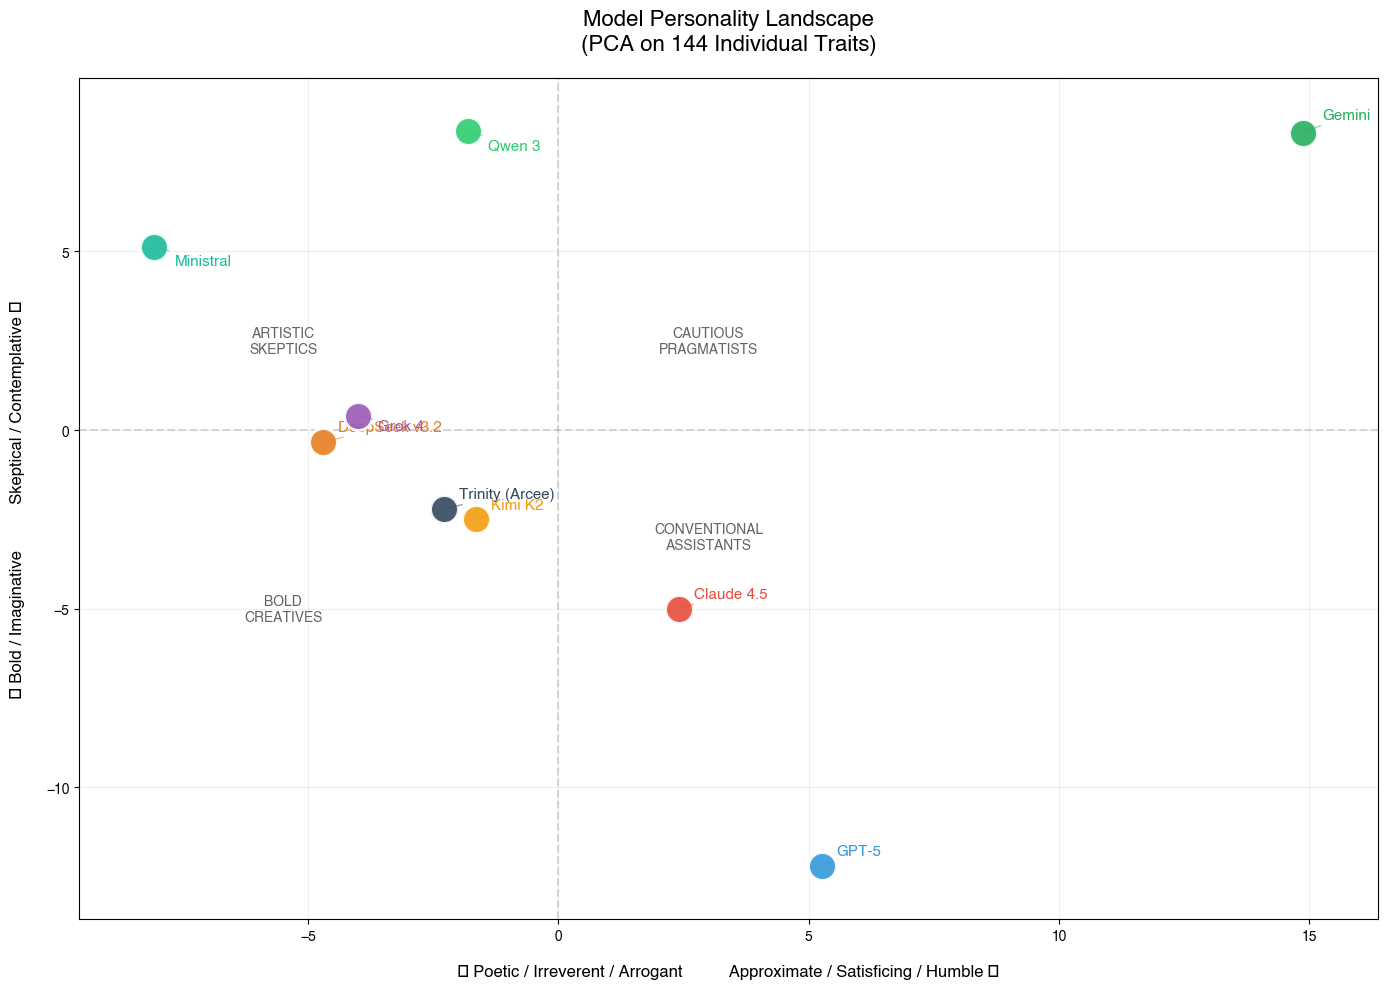


📊 Saved as 'model_personality_landscape.png'


In [39]:
# =============================================================================
# ANNOTATED PCA: Model Personality Landscape
# =============================================================================
# A 2D map with human-interpretable axes showing where each model lives

fig, ax = plt.subplots(figsize=(14, 10))

# Define model colors (unique for each)
model_colors = {
    'claude-haiku-4.5': '#E74C3C',      # Red
    'deepseek-v3.2': '#E67E22',          # Orange  
    'gemini-3-flash-preview': '#27AE60', # Green
    'gpt-5.1': '#3498DB',                # Blue
    'grok-4.1-fast': '#9B59B6',          # Purple
    'kimi-k2-thinking': '#F39C12',       # Yellow
    'ministral-14b-2512': '#1ABC9C',     # Teal
    'qwen3-vl-235b-a22b-thinking': '#2ECC71',  # Lime
    'trinity-mini': '#34495E'            # Dark gray
}

# Plot each model
for i, model in enumerate(valid_models):
    x, y = model_coords[i, 0], model_coords[i, 1]
    color = model_colors.get(model, '#2E86AB')
    name = display_names.get(model, model)
    
    ax.scatter(x, y, s=400, c=color, edgecolors='white', linewidths=2, zorder=3, alpha=0.9)
    
    # Offset labels to avoid overlap
    offset_x, offset_y = 0.3, 0.3
    if 'qwen' in model.lower():
        offset_x, offset_y = 0.4, -0.5
    elif 'gemini' in model.lower():
        offset_x, offset_y = 0.4, 0.4
    elif 'ministral' in model.lower():
        offset_x, offset_y = 0.4, -0.5
    elif 'grok' in model.lower():
        offset_x, offset_y = 0.4, -0.4
        
    ax.annotate(name, (x, y), xytext=(x + offset_x, y + offset_y),
                fontsize=11, fontweight='bold', color=color,
                arrowprops=dict(arrowstyle='-', color=color, alpha=0.5))

# Add quadrant labels
ax.axhline(0, color='gray', linestyle='--', alpha=0.3, zorder=1)
ax.axvline(0, color='gray', linestyle='--', alpha=0.3, zorder=1)

# Quadrant annotations (what each corner means)
ax.text(-5.5, 2.5, "ARTISTIC\nSKEPTICS", fontsize=10, fontweight='bold', 
        color='#666', ha='center', va='center', style='italic')
ax.text(3, 2.5, "CAUTIOUS\nPRAGMATISTS", fontsize=10, fontweight='bold',
        color='#666', ha='center', va='center', style='italic')
ax.text(-5.5, -5, "BOLD\nCREATIVES", fontsize=10, fontweight='bold',
        color='#666', ha='center', va='center', style='italic')
ax.text(3, -3, "CONVENTIONAL\nASSISTANTS", fontsize=10, fontweight='bold',
        color='#666', ha='center', va='center', style='italic')

# Axis labels with interpretation
ax.set_xlabel('← Poetic / Irreverent / Arrogant          Approximate / Satisficing / Humble →', 
              fontsize=12, fontweight='bold', labelpad=15)
ax.set_ylabel('← Bold / Imaginative          Skeptical / Contemplative →', 
              fontsize=12, fontweight='bold', labelpad=15)

ax.set_title('Model Personality Landscape\n(PCA on 144 Individual Traits)', 
             fontsize=16, fontweight='bold', pad=20)

# Set limits with buffer
buffer = 1.5
ax.set_xlim(model_coords[:, 0].min() - buffer, model_coords[:, 0].max() + buffer)
ax.set_ylim(model_coords[:, 1].min() - buffer, model_coords[:, 1].max() + buffer)

ax.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('model_personality_landscape.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print("\n📊 Saved as 'model_personality_landscape.png'")

In [40]:
# =============================================================================
# MODEL SIGNATURES: What Makes Each Model Unique?
# =============================================================================
# For each model, show the traits where it deviates most from the average

# Calculate mean ELO for each trait across all models
mean_elos = elo_matrix.mean(axis=0)
std_elos = elo_matrix.std(axis=0)

# Calculate z-scores for each model (how many SDs from mean)
zscore_matrix = (elo_matrix - mean_elos) / (std_elos + 1e-8)

# For each model, find their most distinctive traits
print("=" * 80)
print("EACH MODEL'S PERSONALITY SIGNATURE")
print("=" * 80)
print("(Traits where each model differs most from the average)\n")

model_signatures = {}

for i, model in enumerate(valid_models):
    name = display_names.get(model, model)
    zscores = zscore_matrix[i]
    
    # Sort by absolute deviation
    sorted_idx = np.argsort(np.abs(zscores))[::-1]
    
    # Get top 6 distinctive traits
    top_traits = []
    for j in sorted_idx[:6]:
        trait = trait_names[j]
        zscore = zscores[j]
        direction = "↑" if zscore > 0 else "↓"
        top_traits.append((trait, zscore, direction))
    
    model_signatures[model] = top_traits
    
    # Print
    print(f"🔹 {name}:")
    for trait, zscore, direction in top_traits:
        bar = "█" * int(min(abs(zscore) * 3, 15))
        print(f"    {direction} {trait:20s} ({zscore:+.2f}σ) {bar}")
    print()

EACH MODEL'S PERSONALITY SIGNATURE
(Traits where each model differs most from the average)

🔹 Claude 4.5:
    ↑ cooperative          (+2.24σ) ██████
    ↓ futuristic           (-2.03σ) ██████
    ↑ questioning          (+2.03σ) ██████
    ↑ idealistic           (+2.01σ) ██████
    ↑ reflective           (+1.96σ) █████
    ↓ competitive          (-1.88σ) █████

🔹 DeepSeek v3.2:
    ↓ precise              (-2.19σ) ██████
    ↓ concrete             (-2.19σ) ██████
    ↓ specialized          (-1.95σ) █████
    ↑ tentative            (+1.83σ) █████
    ↑ indirect             (+1.71σ) █████
    ↓ confident            (-1.62σ) ████

🔹 Gemini:
    ↑ pedantic             (+2.65σ) ███████
    ↑ scholarly            (+2.63σ) ███████
    ↑ visionary            (+2.58σ) ███████
    ↓ reactive             (-2.51σ) ███████
    ↑ systematic           (+2.49σ) ███████
    ↑ tactical             (+2.49σ) ███████

🔹 GPT-5:
    ↑ patient              (+2.48σ) ███████
    ↑ learning             (+2.44σ) ██

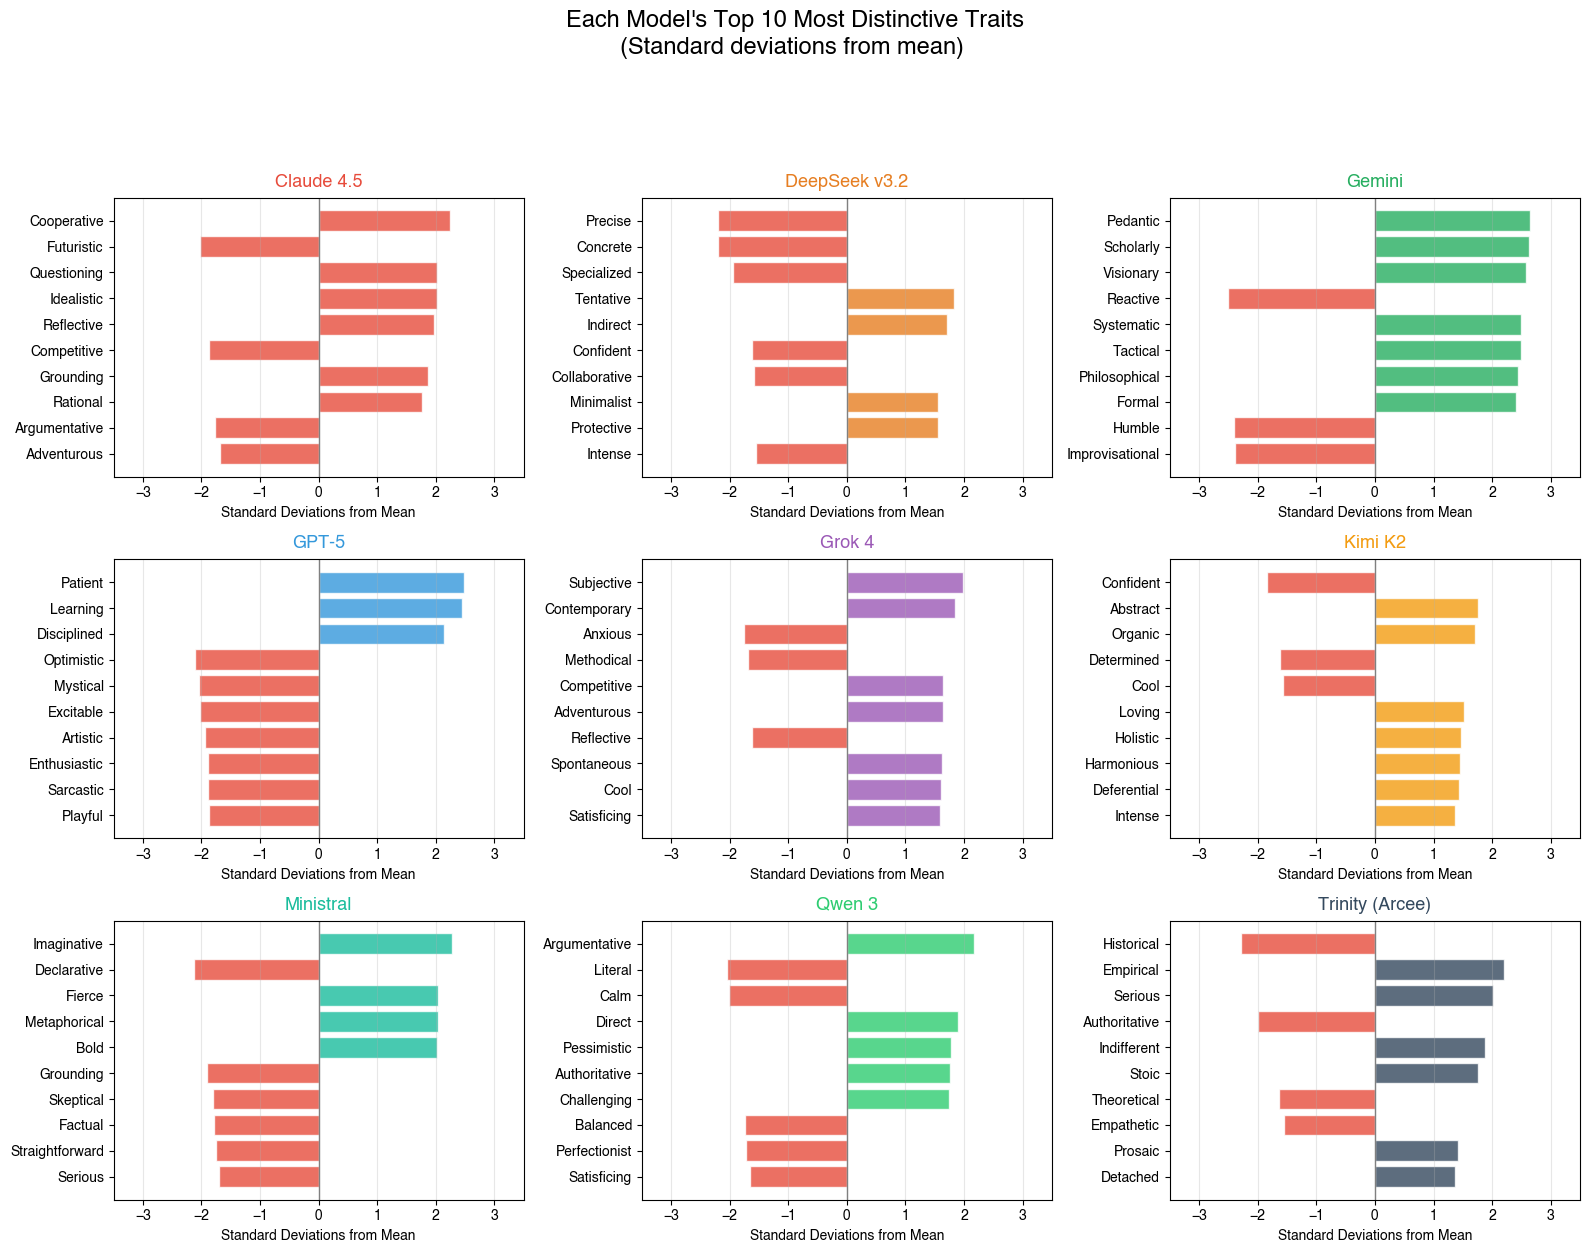


📊 Saved as 'model_distinctiveness_all_models.png'


In [46]:
# =============================================================================
# VISUAL: Model Distinctiveness Cards (ALL MODELS)
# =============================================================================
# A grid showing each model's top 10 most distinctive traits

n_models = len(valid_models)
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))
fig_height = 4 * n_rows if n_rows > 1 else 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, fig_height))
axes = axes.flatten()

for ax_idx, model in enumerate(valid_models):
    ax = axes[ax_idx]
    model_idx = valid_models.index(model)
    name = display_names.get(model, model)
    color = model_colors.get(model, '#2E86AB')
    
    # Get this model's z-scores
    zscores = zscore_matrix[model_idx]

    # Get top 10 most extreme traits (both directions)
    sorted_idx = np.argsort(np.abs(zscores))[::-1][:10]
    
    traits = [trait_names[i].title() for i in sorted_idx]
    values = [zscores[i] for i in sorted_idx]
    colors_bars = [color if v > 0 else '#E74C3C' for v in values]

    # Horizontal bar chart
    y_pos = np.arange(len(traits))
    ax.barh(y_pos, values, color=colors_bars, alpha=0.8, edgecolor='white', linewidth=1)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(traits, fontsize=10)
    ax.axvline(0, color='gray', linestyle='-', linewidth=1)
    ax.set_xlabel('Standard Deviations from Mean', fontsize=10)
    ax.set_title(f'{name}', fontsize=13, fontweight='bold', color=color, pad=8)
    ax.set_xlim(-3.5, 3.5)
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()
    
# Hide any unused axes
for i in range(n_models, len(axes)):
    axes[i].axis('off')

plt.suptitle('Each Model\'s Top 10 Most Distinctive Traits\n(Standard deviations from mean) ',
             fontsize=17, fontweight='bold', y=1.04)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('model_distinctiveness_all_models.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print("\n📊 Saved as 'model_distinctiveness_all_models.png'")

In [42]:
# =============================================================================
# THE CONFORMIST CLUSTER: What the "Average" Assistant Looks Like
# =============================================================================
# GPT-5, Claude, DeepSeek, Kimi K2, and Trinity all cluster together.
# What traits define this mainstream assistant personality?

# Identify the conformist models (those closest to center in PCA)
conformist_idx = np.argsort(distances_from_center)[:5]
conformist_models = [valid_models[i] for i in conformist_idx]

print("=" * 80)
print("THE CONFORMIST CLUSTER")
print("=" * 80)
print("These models cluster tightly together in trait space:\n")
for m in conformist_models:
    dist = distances_from_center[valid_models.index(m)]
    print(f"  • {display_names.get(m, m):20s} (distance from center: {dist:.2f})")

# Calculate the average trait profile for conformist models
conformist_mask = np.isin(valid_models, conformist_models)
conformist_elos = elo_matrix[conformist_mask].mean(axis=0)

# Find traits where conformists agree (low variance) and have strong preference
conformist_std = elo_matrix[conformist_mask].std(axis=0)
conformist_deviation_from_baseline = conformist_elos - 1000  # Deviation from baseline ELO

# Traits they all strongly prefer (high ELO, low variance among themselves)
agreement_score = np.abs(conformist_deviation_from_baseline) / (conformist_std + 1)
sorted_by_agreement = np.argsort(agreement_score)[::-1]

print("\n\nTRAITS THAT DEFINE THE 'MAINSTREAM ASSISTANT':")
print("-" * 50)
print("\n📈 Strongly Preferred (high ELO, high agreement):")
for i in sorted_by_agreement[:8]:
    if conformist_deviation_from_baseline[i] > 0:
        trait = trait_names[i]
        elo = conformist_elos[i]
        std = conformist_std[i]
        print(f"    {trait:20s} (avg ELO: {elo:.0f}, σ: {std:.1f})")

print("\n📉 Strongly Avoided (low ELO, high agreement):")
for i in sorted_by_agreement[:15]:
    if conformist_deviation_from_baseline[i] < -50:
        trait = trait_names[i]
        elo = conformist_elos[i]
        std = conformist_std[i]
        print(f"    {trait:20s} (avg ELO: {elo:.0f}, σ: {std:.1f})")

THE CONFORMIST CLUSTER
These models cluster tightly together in trait space:

  • Kimi K2              (distance from center: 2.99)
  • Trinity (Arcee)      (distance from center: 3.18)
  • Grok 4               (distance from center: 4.04)
  • DeepSeek v3.2        (distance from center: 4.71)
  • Claude 4.5           (distance from center: 5.54)


TRAITS THAT DEFINE THE 'MAINSTREAM ASSISTANT':
--------------------------------------------------

📈 Strongly Preferred (high ELO, high agreement):
    systematic           (avg ELO: 1327, σ: 27.6)
    focused              (avg ELO: 1213, σ: 24.1)
    calm                 (avg ELO: 1183, σ: 23.5)
    structured           (avg ELO: 1352, σ: 49.2)
    straightforward      (avg ELO: 1234, σ: 34.3)

📉 Strongly Avoided (low ELO, high agreement):
    challenging          (avg ELO: 812, σ: 27.2)
    fierce               (avg ELO: 760, σ: 36.3)
    emotional            (avg ELO: 820, σ: 27.0)
    argumentative        (avg ELO: 711, σ: 46.1)
    fooli

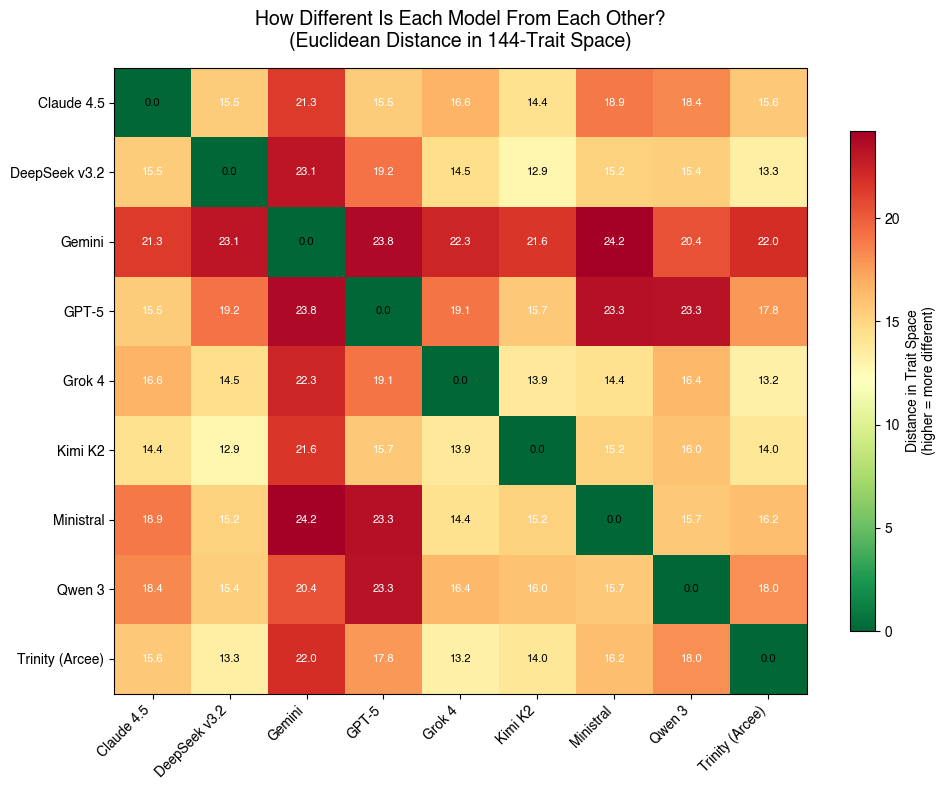


KEY FINDINGS FROM DISTANCE MATRIX

🤝 Most similar pair: DeepSeek v3.2 ↔ Kimi K2 (distance: 12.9)
🔀 Most different pair: Gemini ↔ Ministral (distance: 24.2)

🎯 Most 'central' model (closest to average): Kimi K2
🌟 Most 'isolated' model (furthest from others): Gemini


In [43]:
# =============================================================================
# MODEL DISTANCE MATRIX: How Different Is Each Model From Each Other?
# =============================================================================
# Euclidean distance in the full 144-trait space (not PCA-reduced)

from scipy.spatial.distance import pdist, squareform

# Calculate pairwise distances in normalized trait space
distances = squareform(pdist(elo_normalized, metric='euclidean'))

# Create display names list
model_display = [display_names.get(m, m) for m in valid_models]

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Use a diverging colormap (closer = green, farther = red)
im = ax.imshow(distances, cmap='RdYlGn_r', aspect='auto')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Distance in Trait Space\n(higher = more different)', fontsize=10)

# Set ticks
ax.set_xticks(np.arange(len(model_display)))
ax.set_yticks(np.arange(len(model_display)))
ax.set_xticklabels(model_display, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(model_display, fontsize=10)

# Add distance values
for i in range(len(model_display)):
    for j in range(len(model_display)):
        text_color = 'white' if distances[i, j] > distances.max() * 0.6 else 'black'
        ax.text(j, i, f'{distances[i, j]:.1f}', ha='center', va='center', 
                fontsize=8, color=text_color)

ax.set_title('How Different Is Each Model From Each Other?\n(Euclidean Distance in 144-Trait Space)', 
             fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('model_distance_matrix.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

# Print key findings
print("\n" + "=" * 60)
print("KEY FINDINGS FROM DISTANCE MATRIX")
print("=" * 60)

# Find most similar pair
min_dist = np.inf
min_pair = None
for i in range(len(valid_models)):
    for j in range(i+1, len(valid_models)):
        if distances[i, j] < min_dist:
            min_dist = distances[i, j]
            min_pair = (model_display[i], model_display[j])

# Find most different pair
max_dist = 0
max_pair = None
for i in range(len(valid_models)):
    for j in range(i+1, len(valid_models)):
        if distances[i, j] > max_dist:
            max_dist = distances[i, j]
            max_pair = (model_display[i], model_display[j])

print(f"\n🤝 Most similar pair: {min_pair[0]} ↔ {min_pair[1]} (distance: {min_dist:.1f})")
print(f"🔀 Most different pair: {max_pair[0]} ↔ {max_pair[1]} (distance: {max_dist:.1f})")

# Calculate average distance from each model to all others
avg_distances = distances.sum(axis=1) / (len(valid_models) - 1)
most_central = model_display[np.argmin(avg_distances)]
most_isolated = model_display[np.argmax(avg_distances)]

print(f"\n🎯 Most 'central' model (closest to average): {most_central}")
print(f"🌟 Most 'isolated' model (furthest from others): {most_isolated}")

/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/3358428611.py:48: UserWarning: Glyph 8593 (\N{UPWARDS ARROW}) missing from font(s) Helvetica.
  plt.tight_layout()
/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/3358428611.py:48: UserWarning: Glyph 8595 (\N{DOWNWARDS ARROW}) missing from font(s) Helvetica.
  plt.tight_layout()
/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/3358428611.py:49: UserWarning: Glyph 8593 (\N{UPWARDS ARROW}) missing from font(s) Helvetica.
  plt.savefig('model_weirdness_spectrum.png', dpi=200, bbox_inches='tight', facecolor='white')
/var/folders/wk/5zgfdm_n5h1_8_3hl8wppln00000gp/T/ipykernel_79464/3358428611.py:49: UserWarning: Glyph 8595 (\N{DOWNWARDS ARROW}) missing from font(s) Helvetica.
  plt.savefig('model_weirdness_spectrum.png', dpi=200, bbox_inches='tight', facecolor='white')
/Users/student/Desktop/ai+design/character_elicitation/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWa

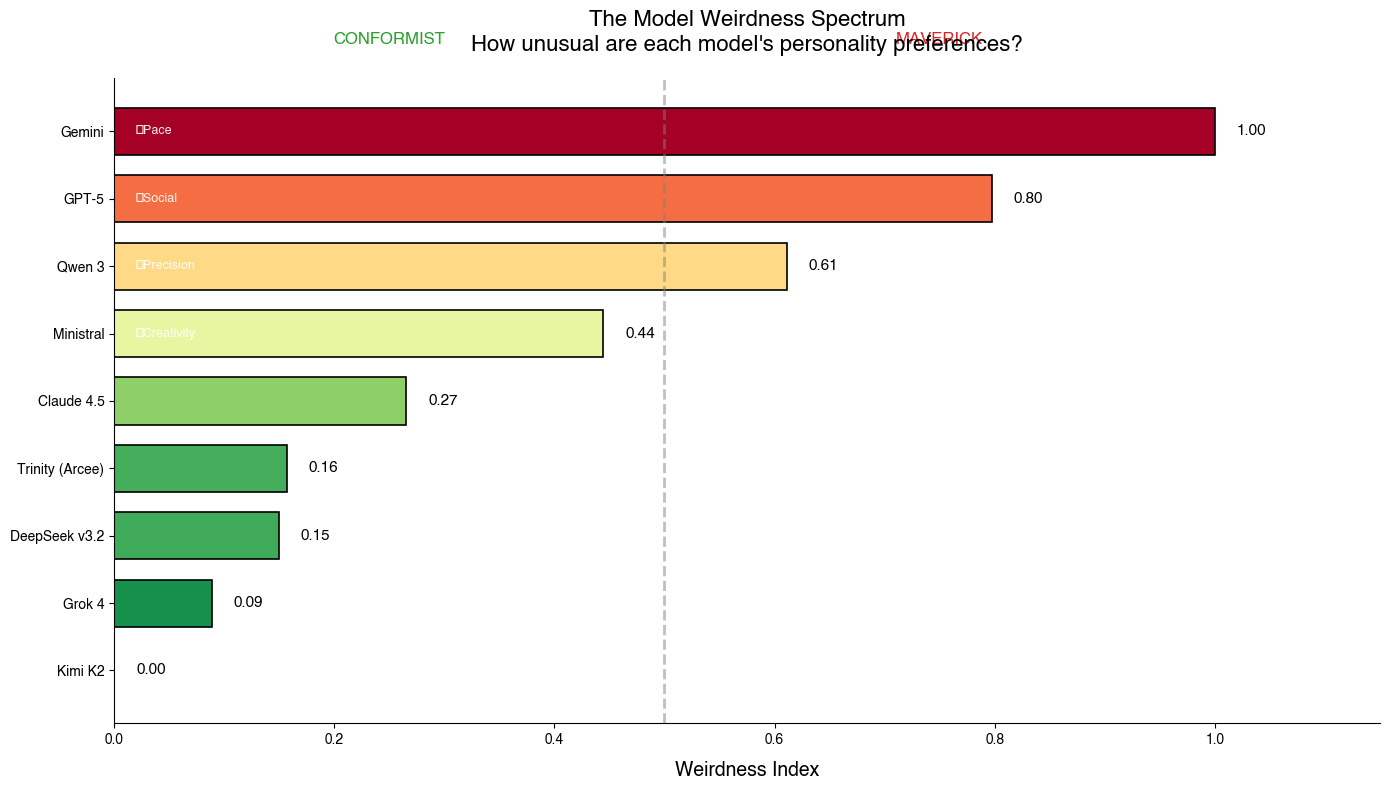


📊 Hero visualization saved as 'model_weirdness_spectrum.png'

Key takeaways for your story:
  1. Gemini is the most distinctive model (weirdness: 1.00)
  2. Kimi K2 most closely matches the 'average' model profile
  3. The weirdness spectrum ranges from 0.00 to 1.00


In [44]:
# =============================================================================
# HERO VISUALIZATION: The Weirdness Spectrum (for presentations/papers)
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

# Sort by weirdness for clean visual
plot_df = weirdness_df.sort_values('WEIRDNESS_INDEX', ascending=True).reset_index()
plot_df.columns = ['Model'] + list(plot_df.columns[1:])

# Create gradient colormap based on weirdness
cmap = plt.cm.RdYlGn_r
norm = plt.Normalize(plot_df['WEIRDNESS_INDEX'].min(), plot_df['WEIRDNESS_INDEX'].max())

# Main horizontal bar chart
bars = ax.barh(plot_df['Model'], plot_df['WEIRDNESS_INDEX'], 
               color=[cmap(norm(v)) for v in plot_df['WEIRDNESS_INDEX']],
               edgecolor='black', linewidth=1.2, height=0.7)

# Add distinctive feature annotations
for i, (_, row) in enumerate(plot_df.iterrows()):
    model = row['Model']
    weird_idx = row['WEIRDNESS_INDEX']
    max_cluster = row['max_dev_cluster'].split()[0]  # First word only
    direction = "↑" if row['max_dev_direction'] == 'high' else "↓"
    
    # Value label
    ax.text(weird_idx + 0.02, i, f'{weird_idx:.2f}', va='center', fontsize=11, fontweight='bold')
    
    # What makes them weird (annotation)
    if weird_idx > 0.3:
        ax.text(0.02, i, f'{direction}{max_cluster}', va='center', fontsize=9, 
                color='white', fontweight='bold', alpha=0.9)

# Style
ax.set_xlim(0, 1.15)
ax.set_xlabel('Weirdness Index', fontsize=14, fontweight='bold', labelpad=10)
ax.set_title('The Model Weirdness Spectrum\nHow unusual are each model\'s personality preferences?', 
             fontsize=16, fontweight='bold', pad=20)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=2)
ax.text(0.25, len(plot_df) + 0.3, 'CONFORMIST', ha='center', fontsize=12, fontweight='bold', color='#2ca02c')
ax.text(0.75, len(plot_df) + 0.3, 'MAVERICK', ha='center', fontsize=12, fontweight='bold', color='#d62728')

# Remove spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('model_weirdness_spectrum.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print("\n📊 Hero visualization saved as 'model_weirdness_spectrum.png'")
print("\nKey takeaways for your story:")
print(f"  1. {plot_df.iloc[-1]['Model']} is the most distinctive model (weirdness: {plot_df.iloc[-1]['WEIRDNESS_INDEX']:.2f})")
print(f"  2. {plot_df.iloc[0]['Model']} most closely matches the 'average' model profile")
print(f"  3. The weirdness spectrum ranges from {plot_df['WEIRDNESS_INDEX'].min():.2f} to {plot_df['WEIRDNESS_INDEX'].max():.2f}")